In [1]:
!pip install sodapy
!pip install Unidecode

In [2]:
import pandas as pd
from sodapy import Socrata
from datetime import datetime, timedelta, date
from unidecode import unidecode
import copy

## Morbilidades


In [3]:
def read_csv_url(url):
  df = pd.read_csv(url)
  return df

In [4]:
df_morbilidades_crudo = read_csv_url("https://raw.githubusercontent.com/MiguelMque/covid19/master/tarea14/data/MORBILIDAD.csv?token=AHPH4XI6QFKCOXFF3WL3SVS7DIQMI")
df_morbilidades_crudo = df_morbilidades_crudo.rename(
    columns={
        "Gran causa de morbilidad": "causa_morbilidad",
        "Subgrupo de causas": "morbilidad",
        "Sexo": "sexo",
        "Núm.  Personas 2012": "cantidad_morbilidad"
    }
)
df_morbilidades_crudo = df_morbilidades_crudo.drop(columns=['id_depto', 'causa_morbilidad', 'sexo'])
df_morbilidades_crudo["nom_depto"] = df_morbilidades_crudo["nom_depto"].str.lower()
df_morbilidades_crudo["nom_depto"] = df_morbilidades_crudo["nom_depto"].transform(lambda x: unidecode(x))
df_morbilidades_crudo["nom_depto"] = df_morbilidades_crudo["nom_depto"].transform(lambda x: x if x != "archipielago de san andres, providencia y santa catalina" else "san andres y providencia")
df_morbilidades_crudo["nom_depto"] = df_morbilidades_crudo["nom_depto"].transform(lambda x: x if x != "bogota d.c" else "bogota")
df_morbilidades_crudo = df_morbilidades_crudo.dropna(subset=['morbilidad'])
df_morbilidades_crudo = df_morbilidades_crudo.sort_values(by=["nom_depto", "morbilidad"]).reset_index(drop=True)
df_morbilidades_crudo["morbilidad"] = df_morbilidades_crudo["morbilidad"].str.lower()
df_morbilidades_crudo["morbilidad"] = df_morbilidades_crudo["morbilidad"].transform(lambda x: unidecode(x))
df_morbilidades_crudo["morbilidad"] = df_morbilidades_crudo["morbilidad"].transform(lambda x: x.replace(' ', '_'))
df_morbilidades_crudo["morbilidad"] = df_morbilidades_crudo["morbilidad"].transform(lambda x: x.replace(',', '_'))
df_morbilidades_crudo["morbilidad"] = df_morbilidades_crudo["morbilidad"].transform(lambda x: x.replace('-', '_'))
df_morbilidades_crudo.head(1)

,nom_depto,morbilidad,cantidad_morbilidad
0,amazonas,anomalias_congenitas,44


In [5]:
# agrupar por morbilidad sumando cantidad_morbilidad
df_morbilidades_departamento = df_morbilidades_crudo.groupby(["morbilidad", "nom_depto"])["cantidad_morbilidad"].sum().reset_index()
df_morbilidades_departamento = df_morbilidades_departamento.sort_values(by=["nom_depto", "morbilidad"]).reset_index(drop=True)
df_morbilidades_departamento.head(1)

,morbilidad,nom_depto,cantidad_morbilidad
0,anomalias_congenitas,amazonas,328


In [6]:
# morbilidades queden como columnas
df_morbilidades = df_morbilidades_departamento.pivot(index="nom_depto", columns="morbilidad", values="cantidad_morbilidad")
df_morbilidades['departamento'] = df_morbilidades.index
df_morbilidades = df_morbilidades.reset_index(drop=True)
df_morbilidades.head(1)

morbilidad,anomalias_congenitas,codiciones_orales,condiciones_derivadas_durante_el_periodo_perinatal,condiciones_maternas,condiciones_neuropsiquiatricas,deficiencias_nutricionales,desordenes_endocrinos,diabetes_mellitus,enfermedades_cardiovasculares,enfermedades_de_la_piel,enfermedades_de_los_organos_de_los_sentidos,enfermedades_digestivas,enfermedades_genitourinarias,enfermedades_infecciosas_y_parasitarias,enfermedades_musculo_esqueleticas,enfermedades_respiratorias,infecciones_respiratorias,lesiones_de_intensionalidad_indeterminada,lesiones_intensionales,lesiones_no_intensionales,neoplasias_malignas,otras_neoplasias,signos_y_sintomas_mal_definidos,traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas,departamento
0,328.0,11292.0,68.0,828.0,1680.0,448.0,2132.0,704.0,2636.0,2396.0,2408.0,2420.0,4320.0,5628.0,4252.0,1820.0,4476.0,NaN,4.0,116.0,332.0,516.0,7102.0,2540.0,amazonas


## Cargando datasets variables constantes




In [7]:
df_densidad_poblacional = read_csv_url("https://raw.githubusercontent.com/MiguelMque/covid19/master/tarea14/data/densidad_poblacional_x_departamento.csv?token=AHPH4XJ6BODICNAPZ7OMWKK7DIQPO")
df_densidad_poblacional["departamento"] = df_densidad_poblacional["departamento"].str.lower()
df_densidad_poblacional["departamento"] = df_densidad_poblacional["departamento"].transform(lambda x: unidecode(x))
df_densidad_poblacional["departamento"] = df_densidad_poblacional["departamento"].transform(lambda x: x if x != "bogota d.c" else "bogota")
df_densidad_poblacional = df_densidad_poblacional[df_densidad_poblacional["departamento"] != "colombia"]
df_densidad_poblacional = df_densidad_poblacional.drop(columns=['superficie(km2)'])
df_densidad_poblacional.head()

,departamento,poblacion,personas por km2
0,amazonas,78830,0.719
1,antioquia,6690977,105.184
2,arauca,270708,11.366
3,atlantico,2546138,751.517
4,bogota,8181047,5155.039


In [8]:
df_edad_promedio = read_csv_url("https://raw.githubusercontent.com/MiguelMque/covid19/master/tarea14/data/edad_promedio.csv?token=AHPH4XMSRIUBCMURX64R74C7DIQPS")
df_edad_promedio["departamento"] = df_edad_promedio["departamento"].transform(lambda x: unidecode(x))
df_edad_promedio.head(1)

,departamento,cantidad_casos,edad_promedio
0,antioquia,5974788,34.628


In [9]:
df_indice_pobreza_municipio = read_csv_url("https://raw.githubusercontent.com/MiguelMque/covid19/master/tarea14/data/indice_pobreza.csv?token=AHPH4XIFMOIL4M2SRW5KGXC7DIQPU")
df_indice_pobreza = (
    df_indice_pobreza_municipio.groupby("Codigo Departamento")["Total "]
    .mean()
    .reset_index()
    .rename(columns={"Codigo Departamento": "codigo_departamento", "Total ": "total"})
)
df_indice_pobreza.head(1)

,codigo_departamento,total
0,5,37.5864


In [10]:
df_mayores_65 = read_csv_url("https://raw.githubusercontent.com/MiguelMque/covid19/master/tarea14/data/mayores_65.csv?token=AHPH4XN3RRMBG55PVY4P7KK7DIQPW")
df_mayores_65.head(1)

,Código,Nombre del Departamento,Total
0,5,ANTIOQUIA,576614


## Uniendo datasets variables constantes




In [11]:
# Merge df_indice_pobreza con df_mayores_65
df_pobreza_65 = df_indice_pobreza.merge(
    df_mayores_65, how="outer", left_on="codigo_departamento", right_on="Código",
)
df_pobreza_65 = df_pobreza_65[["Nombre del Departamento", "Total", "total"]]
df_pobreza_65 = df_pobreza_65.rename(
    columns={
        "Nombre del Departamento": "departamento",
        "Total": "cantidad_mayores_65",
        "total": "ipm",
    }
)
df_pobreza_65["departamento"] = df_pobreza_65["departamento"].str.lower()
df_pobreza_65["departamento"] = df_pobreza_65["departamento"].transform(
    lambda x: unidecode(x)
)
df_pobreza_65["departamento"] = df_pobreza_65["departamento"].transform(
    lambda x: unidecode(x)
    if x != "san andres, providencia y santa catalina"
    else "san andres y providencia"
)
df_pobreza_65 = df_pobreza_65.sort_values(by=["departamento"])
df_pobreza_65.head(1)

,departamento,cantidad_mayores_65,ipm
28,amazonas,2791,81.690909


In [12]:
# Merge df_densidad_poblacional con df_edad_promedio
df_densidad_edad = df_densidad_poblacional.merge(
    df_edad_promedio, how="outer", left_on="departamento", right_on="departamento"
)
df_densidad_edad = df_densidad_edad.sort_values(by=["departamento"])
df_densidad_edad = df_densidad_edad[
    [
        "departamento",
        "poblacion",
        "personas por km2",
        "edad_promedio",
    ]
]
df_densidad_edad = df_densidad_edad.rename(
    columns={
        "poblacion": "poblacion_total",
        "personas por km2": "personas_km2",
    }
)
df_densidad_edad = df_densidad_edad.drop([33])
df_densidad_edad.head(1)

,departamento,poblacion_total,personas_km2,edad_promedio
0,amazonas,78830.0,0.719,25.42


In [13]:
# Merge df_pobreza_65 con df_densidad_edad
df_variables_constantes_1 = df_pobreza_65.merge(
    df_densidad_edad, how="outer", left_on="departamento", right_on="departamento"
)
# En INS no esta guania, guaviare, vichada
df_variables_constantes_1 = df_variables_constantes_1.drop([15, 16, 32])
df_variables_constantes_1.head(1)

,departamento,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio
0,amazonas,2791,81.690909,78830.0,0.719,25.42


In [14]:
# Merge variables constantes con morbilidades
df_variables_constantes = df_variables_constantes_1.merge(
    df_morbilidades, how="inner", left_on="departamento", right_on="departamento"
)
df_variables_constantes.head(1)

,departamento,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio,anomalias_congenitas,codiciones_orales,condiciones_derivadas_durante_el_periodo_perinatal,condiciones_maternas,condiciones_neuropsiquiatricas,deficiencias_nutricionales,desordenes_endocrinos,diabetes_mellitus,enfermedades_cardiovasculares,enfermedades_de_la_piel,enfermedades_de_los_organos_de_los_sentidos,enfermedades_digestivas,enfermedades_genitourinarias,enfermedades_infecciosas_y_parasitarias,enfermedades_musculo_esqueleticas,enfermedades_respiratorias,infecciones_respiratorias,lesiones_de_intensionalidad_indeterminada,lesiones_intensionales,lesiones_no_intensionales,neoplasias_malignas,otras_neoplasias,signos_y_sintomas_mal_definidos,traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas
0,amazonas,2791,81.690909,78830.0,0.719,25.42,328.0,11292.0,68.0,828.0,1680.0,448.0,2132.0,704.0,2636.0,2396.0,2408.0,2420.0,4320.0,5628.0,4252.0,1820.0,4476.0,NaN,4.0,116.0,332.0,516.0,7102.0,2540.0


In [15]:
# Dataframe variables constantes por dia
df_variables_constantes_dia = pd.DataFrame(columns=["fecha"]+df_variables_constantes.columns.to_list())
df_fecha = pd.date_range(start=datetime(2020, 3, 2), end = datetime.now()-timedelta(days=2)).to_frame(index=False, name="fecha")
for i, row_i in df_fecha.iterrows():
  for j, row_j in df_variables_constantes.iterrows():
    values = {
        "fecha": datetime.strftime(row_i.fecha, '%Y-%m-%d'), 
        "departamento": row_j.departamento,
        "cantidad_mayores_65": row_j.cantidad_mayores_65,
        "ipm": row_j.ipm,
        "poblacion_total": row_j.poblacion_total,
        "personas_km2": row_j.personas_km2,
        "edad_promedio": row_j.edad_promedio,
        'anomalias_congenitas': row_j.anomalias_congenitas,
        'codiciones_orales': row_j.codiciones_orales,
        'condiciones_derivadas_durante_el_periodo_perinatal': row_j.condiciones_derivadas_durante_el_periodo_perinatal,
        'condiciones_maternas': row_j.condiciones_maternas,
        'condiciones_neuropsiquiatricas': row_j.condiciones_neuropsiquiatricas,
        'deficiencias_nutricionales': row_j.deficiencias_nutricionales,
        'desordenes_endocrinos': row_j.desordenes_endocrinos,
        'diabetes_mellitus': row_j.diabetes_mellitus,
        'enfermedades_cardiovasculares': row_j.enfermedades_cardiovasculares,
        'enfermedades_de_la_piel': row_j.enfermedades_de_la_piel,
        'enfermedades_de_los_organos_de_los_sentidos': row_j.enfermedades_de_los_organos_de_los_sentidos,
        'enfermedades_digestivas': row_j.enfermedades_digestivas,
        'enfermedades_genitourinarias': row_j.enfermedades_genitourinarias,
        'enfermedades_infecciosas_y_parasitarias': row_j.enfermedades_infecciosas_y_parasitarias,
        'enfermedades_musculo_esqueleticas': row_j.enfermedades_musculo_esqueleticas,
        'enfermedades_respiratorias': row_j.enfermedades_respiratorias,
        'infecciones_respiratorias': row_j.infecciones_respiratorias,
        'lesiones_de_intensionalidad_indeterminada': row_j.lesiones_de_intensionalidad_indeterminada,
        'lesiones_intensionales': row_j.lesiones_intensionales,
        'lesiones_no_intensionales': row_j.lesiones_no_intensionales,
        'neoplasias_malignas': row_j.neoplasias_malignas,
        'otras_neoplasias': row_j.otras_neoplasias,
        'signos_y_sintomas_mal_definidos': row_j.signos_y_sintomas_mal_definidos,
        'traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas': row_j.traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas
    }
    df_variables_constantes_dia = df_variables_constantes_dia.append(values, ignore_index=True)
df_variables_constantes_dia[df_variables_constantes_dia['departamento'] == 'cordoba'].tail(3)

,fecha,departamento,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio,anomalias_congenitas,codiciones_orales,condiciones_derivadas_durante_el_periodo_perinatal,condiciones_maternas,condiciones_neuropsiquiatricas,deficiencias_nutricionales,desordenes_endocrinos,diabetes_mellitus,enfermedades_cardiovasculares,enfermedades_de_la_piel,enfermedades_de_los_organos_de_los_sentidos,enfermedades_digestivas,enfermedades_genitourinarias,enfermedades_infecciosas_y_parasitarias,enfermedades_musculo_esqueleticas,enfermedades_respiratorias,infecciones_respiratorias,lesiones_de_intensionalidad_indeterminada,lesiones_intensionales,lesiones_no_intensionales,neoplasias_malignas,otras_neoplasias,signos_y_sintomas_mal_definidos,traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas
3973,2020-07-12,cordoba,130407,53.45,1788648.0,714.887,31.305,13674.0,311828.0,5970.0,54860.0,108318.0,75406.0,123286.0,38968.0,217360.0,168458.0,153818.0,190854.0,410046.0,290464.0,283604.0,108388.0,378222.0,84.0,298.0,47860.0,12154.0,33516.0,481762.0,145144.0
4003,2020-07-13,cordoba,130407,53.45,1788648.0,714.887,31.305,13674.0,311828.0,5970.0,54860.0,108318.0,75406.0,123286.0,38968.0,217360.0,168458.0,153818.0,190854.0,410046.0,290464.0,283604.0,108388.0,378222.0,84.0,298.0,47860.0,12154.0,33516.0,481762.0,145144.0
4033,2020-07-14,cordoba,130407,53.45,1788648.0,714.887,31.305,13674.0,311828.0,5970.0,54860.0,108318.0,75406.0,123286.0,38968.0,217360.0,168458.0,153818.0,190854.0,410046.0,290464.0,283604.0,108388.0,378222.0,84.0,298.0,47860.0,12154.0,33516.0,481762.0,145144.0


## Datos Infectados, Recuperados y Decesos

In [16]:
client = Socrata("www.datos.gov.co", None)
results = client.get("gt2j-8ykr", limit=1000000)
df_casos = pd.DataFrame.from_records(results)
df_casos = df_casos.fillna("-   -")

# Transformacion campos tipo fecha
df_casos["fecha_diagnostico"] = df_casos["fecha_diagnostico"].transform(lambda x: x[:10] if x != "-   -" else x)
df_casos["fis"] = df_casos["fis"].transform(lambda x: x[:10] if x != "-   -" else x)
df_casos["fecha_de_muerte"] = df_casos["fecha_de_muerte"].transform(lambda x: x[:10] if x != "-   -" else x)
df_casos["fecha_de_notificaci_n"] = df_casos["fecha_de_notificaci_n"].transform(lambda x: x[:10] if x != "-   -" else x)
df_casos["fecha_recuperado"] = df_casos["fecha_recuperado"].transform(lambda x: x[:10] if x != "-   -" else x)
df_casos["fecha_reporte_web"] = df_casos["fecha_reporte_web"].transform(lambda x: x[:10] if x != "-   -" else x)

# Tranformacion nombres departamentos
df_casos["departamento"] = df_casos["departamento"].str.lower()
df_casos["departamento"] = df_casos["departamento"].transform(lambda x: unidecode(x))
df_casos["departamento"] = df_casos["departamento"].transform(lambda x: x if x != "bogota d.c." else "bogota")
df_casos["departamento"] = df_casos["departamento"].transform(lambda x: x if "archipielago" not in x else "san andres y providencia")
df_casos["departamento"] = df_casos["departamento"].transform(lambda x: x if x != "cartagena d.t. y c." else "bolivar")
df_casos["departamento"] = df_casos["departamento"].transform(lambda x: x if x != "barranquilla d.e." else "atlantico")
df_casos["departamento"] = df_casos["departamento"].transform(lambda x: x if x != "buenaventura d.e." else "valle del cauca")
df_casos["departamento"] = df_casos["departamento"].transform(lambda x: x if x != "santa marta d.t. y c." else "magdalena")

df_casos.head(1) #.columns.to_list()

,id_de_caso,fecha_de_notificaci_n,c_digo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,estado,pa_s_de_procedencia,fis,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperaci_n,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_de_muerte
0,1,2020-03-02,11001,Bogotá D.C.,bogota,Recuperado,19,F,Importado,Leve,ITALIA,2020-02-27,2020-03-06,2020-03-13,2020-03-06,PCR,11,380,Otro,- -,- -


In [17]:
# Cantidad de infectados en total
df_casos.shape[0]

165169

In [18]:
# Cantidad de fallecidos en total
df_casos[df_casos["fecha_de_muerte"] != '-   -']["fecha_de_muerte"].shape[0]

5966

In [19]:
# Cantidad de recuperados en total
df_casos[df_casos["fecha_recuperado"] != '-   -']["fecha_recuperado"].shape[0]

46985

In [20]:
# Total x departamento
df_cuenta_departamento = (
    df_casos.groupby("departamento")["id_de_caso"]
    .count()
    .reset_index()
    .rename(columns={"id_de_caso": "infectados"})
)
df_fallecidos_departamento = (
    df_casos[df_casos["fecha_de_muerte"] != "-   -"]
    .groupby("departamento")["fecha_de_muerte"]
    .count()
    .reset_index()
    .rename(columns={"fecha_de_muerte": "decesos"})
)
df_recuperados_departamento = (
    df_casos[df_casos["fecha_recuperado"] != "-   -"]
    .groupby("departamento")["fecha_recuperado"]
    .count()
    .reset_index()
    .rename(columns={"fecha_recuperado": "recuperados"})
)

# Merge de los 3 dfs
df_cuenta_departamento = df_cuenta_departamento.merge(
    df_fallecidos_departamento,
    how="outer",
    left_on="departamento",
    right_on="departamento",
)
df_cuenta_departamento = df_cuenta_departamento.merge(
    df_recuperados_departamento,
    how="outer",
    left_on="departamento",
    right_on="departamento",
)
df_cuenta_departamento = df_cuenta_departamento.fillna(0)
df_cuenta_departamento.head(2)

,departamento,infectados,decesos,recuperados
0,amazonas,2433,103.0,2032
1,antioquia,11351,129.0,1978


In [21]:
# Merge dataset variables constantes con total I, R, D
df_ird_constantes = df_cuenta_departamento.merge(
    df_variables_constantes,
    how="outer",
    left_on="departamento",
    right_on="departamento",
)
# En INS no esta guania, guaviare, vichada
df_ird_constantes = df_ird_constantes.dropna()
df_ird_constantes = df_ird_constantes.sort_values(by=["departamento"])
df_ird_constantes.head(3)

,departamento,infectados,decesos,recuperados,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio,anomalias_congenitas,codiciones_orales,condiciones_derivadas_durante_el_periodo_perinatal,condiciones_maternas,condiciones_neuropsiquiatricas,deficiencias_nutricionales,desordenes_endocrinos,diabetes_mellitus,enfermedades_cardiovasculares,enfermedades_de_la_piel,enfermedades_de_los_organos_de_los_sentidos,enfermedades_digestivas,enfermedades_genitourinarias,enfermedades_infecciosas_y_parasitarias,enfermedades_musculo_esqueleticas,enfermedades_respiratorias,infecciones_respiratorias,lesiones_de_intensionalidad_indeterminada,lesiones_intensionales,lesiones_no_intensionales,neoplasias_malignas,otras_neoplasias,signos_y_sintomas_mal_definidos,traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas
1,antioquia,11351,129.0,1978,576614.0,37.586400,6690977.0,105.184,34.628,77776.0,1441756.0,33730.0,222582.0,850400.0,67454.0,761556.0,288104.0,1548418.0,856284.0,1165008.0,915700.0,1431330.0,1214796.0,1699124.0,602088.0,1489768.0,366.0,3640.0,62904.0,142530.0,183648.0,2716784.0,938382.0
2,arauca,160,0.0,46,13880.0,44.457143,270708.0,11.366,29.092,2036.0,34944.0,1060.0,5640.0,10506.0,2932.0,9348.0,3274.0,17604.0,12780.0,22234.0,15142.0,32520.0,25708.0,21556.0,8108.0,24854.0,16.0,100.0,1074.0,1268.0,4222.0,48664.0,15424.0
3,atlantico,36425,2024.0,8980,196909.0,37.326087,2546138.0,751.517,32.435,39482.0,490292.0,13216.0,92378.0,276326.0,63446.0,269384.0,94614.0,528492.0,379022.0,426452.0,413394.0,669408.0,598656.0,648180.0,261712.0,620138.0,668.0,1314.0,25066.0,27472.0,72974.0,1032222.0,312074.0


In [22]:
# Total x dia x departamento
df_cuenta_departamento_dia = (
    df_casos.groupby(["fecha_reporte_web", "departamento"])["id_de_caso"]
    .count()
    .reset_index()
    .rename(columns={"id_de_caso": "infectados"})
)
df_fallecidos_departamento_dia = (
    df_casos[df_casos["fecha_de_muerte"] != "-   -"]
    .groupby(["fecha_reporte_web", "departamento"])["fecha_de_muerte"]
    .count()
    .reset_index()
    .rename(columns={"fecha_de_muerte": "decesos"})
)
df_recuperados_departamento_dia = (
    df_casos[df_casos["fecha_recuperado"] != "-   -"]
    .groupby(["fecha_reporte_web", "departamento"])["fecha_recuperado"]
    .count()
    .reset_index()
    .rename(columns={"fecha_recuperado": "recuperados"})
)

df_cuenta_departamento_dia = df_cuenta_departamento_dia.merge(
    df_fallecidos_departamento_dia,
    how="outer",
    left_on=["fecha_reporte_web", "departamento"],
    right_on=["fecha_reporte_web", "departamento"],
)
df_cuenta_departamento_dia = df_cuenta_departamento_dia.merge(
    df_recuperados_departamento_dia,
    how="outer",
    left_on=["fecha_reporte_web", "departamento"],
    right_on=["fecha_reporte_web", "departamento"],
)
df_cuenta_departamento_dia = df_cuenta_departamento_dia.fillna(0)
df_cuenta_departamento_dia.groupby(["fecha_reporte_web"])["departamento"].count().tail(30)

fecha_reporte_web
2020-06-16    26
2020-06-17    26
2020-06-18    28
2020-06-19    28
2020-06-20    27
2020-06-21    27
2020-06-22    26
2020-06-23    27
2020-06-24    26
2020-06-25    25
2020-06-26    24
2020-06-27    26
2020-06-28    26
2020-06-29    25
2020-06-30    24
2020-07-01    26
2020-07-02    29
2020-07-03    25
2020-07-04    27
2020-07-05    24
2020-07-06    26
2020-07-07    25
2020-07-08    28
2020-07-09    29
2020-07-10    28
2020-07-11    25
2020-07-12    29
2020-07-13    26
2020-07-14    27
2020-07-15    28
Name: departamento, dtype: int64

In [23]:
# Total x dia x departamento + variables constantes
df_ird_constantes_dia = df_cuenta_departamento_dia.merge(
    df_variables_constantes_dia,
    how="outer",
    left_on=["fecha_reporte_web", "departamento"],
    right_on=["fecha", "departamento"],
)
df_ird_constantes_dia = df_ird_constantes_dia[
    [
        "fecha",
        "departamento",
        "infectados",
        "recuperados",
        "decesos",
        "cantidad_mayores_65",
        "ipm",
        "poblacion_total",
        "personas_km2",
        "edad_promedio",
        'anomalias_congenitas',
        'codiciones_orales',
        'condiciones_derivadas_durante_el_periodo_perinatal',
        'condiciones_maternas',
        'condiciones_neuropsiquiatricas',
        'deficiencias_nutricionales',
        'desordenes_endocrinos',
        'diabetes_mellitus',
        'enfermedades_cardiovasculares',
        'enfermedades_de_la_piel',
        'enfermedades_de_los_organos_de_los_sentidos',
        'enfermedades_digestivas',
        'enfermedades_genitourinarias',
        'enfermedades_infecciosas_y_parasitarias',
        'enfermedades_musculo_esqueleticas',
        'enfermedades_respiratorias',
        'infecciones_respiratorias',
        'lesiones_de_intensionalidad_indeterminada',
        'lesiones_intensionales',
        'lesiones_no_intensionales',
        'neoplasias_malignas',
        'otras_neoplasias',
        'signos_y_sintomas_mal_definidos',
        'traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas',
    ]
]
df_ird_constantes_dia = df_ird_constantes_dia[df_ird_constantes_dia['fecha'].notna()]
df_ird_constantes_dia = df_ird_constantes_dia.fillna(0)
df_ird_constantes_dia = df_ird_constantes_dia.sort_values(by=['fecha', 'departamento']).reset_index(drop=True)
df_ird_constantes_dia.tail(1)

,fecha,departamento,infectados,recuperados,decesos,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio,anomalias_congenitas,codiciones_orales,condiciones_derivadas_durante_el_periodo_perinatal,condiciones_maternas,condiciones_neuropsiquiatricas,deficiencias_nutricionales,desordenes_endocrinos,diabetes_mellitus,enfermedades_cardiovasculares,enfermedades_de_la_piel,enfermedades_de_los_organos_de_los_sentidos,enfermedades_digestivas,enfermedades_genitourinarias,enfermedades_infecciosas_y_parasitarias,enfermedades_musculo_esqueleticas,enfermedades_respiratorias,infecciones_respiratorias,lesiones_de_intensionalidad_indeterminada,lesiones_intensionales,lesiones_no_intensionales,neoplasias_malignas,otras_neoplasias,signos_y_sintomas_mal_definidos,traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas
4049,2020-07-14,vaupes,0.0,0.0,0.0,1431,88.766667,44928.0,0.83,22.849,116.0,2496.0,8.0,184.0,312.0,168.0,228.0,100.0,432.0,696.0,400.0,604.0,792.0,1648.0,912.0,208.0,948.0,0.0,0.0,12.0,48.0,72.0,1248.0,660.0


In [24]:
# Total x dia x departamento (acumulado)
df_cuenta_departamento_acum = copy.deepcopy(df_cuenta_departamento_dia)
df_cuenta_departamento_acum["infectados"] = df_cuenta_departamento_dia.groupby(["departamento"])["infectados"].cumsum()
df_cuenta_departamento_acum["decesos"] = df_cuenta_departamento_dia.groupby(["departamento"])["decesos"].cumsum()
df_cuenta_departamento_acum["recuperados"] = df_cuenta_departamento_dia.groupby(["departamento"])["recuperados"].cumsum()
df_cuenta_departamento_acum.tail(1)

,fecha_reporte_web,departamento,infectados,decesos,recuperados
2338,2020-07-15,vaupes,61,1.0,21.0


In [25]:
# Total x dia x departamento (acumulado) + variables constantes
df_ird_constantes_acum = df_cuenta_departamento_acum.merge(
    df_variables_constantes_dia,
    how="outer",
    left_on=["fecha_reporte_web", "departamento"],
    right_on=["fecha", "departamento"],
)
df_ird_constantes_acum = df_ird_constantes_acum[
    [
        "fecha",
        "departamento",
        "infectados",
        "recuperados",
        "decesos",
        "cantidad_mayores_65",
        "ipm",
        "poblacion_total",
        "personas_km2",
        "edad_promedio",
        'anomalias_congenitas',
        'codiciones_orales',
        'condiciones_derivadas_durante_el_periodo_perinatal',
        'condiciones_maternas',
        'condiciones_neuropsiquiatricas',
        'deficiencias_nutricionales',
        'desordenes_endocrinos',
        'diabetes_mellitus',
        'enfermedades_cardiovasculares',
        'enfermedades_de_la_piel',
        'enfermedades_de_los_organos_de_los_sentidos',
        'enfermedades_digestivas',
        'enfermedades_genitourinarias',
        'enfermedades_infecciosas_y_parasitarias',
        'enfermedades_musculo_esqueleticas',
        'enfermedades_respiratorias',
        'infecciones_respiratorias',
        'lesiones_de_intensionalidad_indeterminada',
        'lesiones_intensionales',
        'lesiones_no_intensionales',
        'neoplasias_malignas',
        'otras_neoplasias',
        'signos_y_sintomas_mal_definidos',
        'traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas',
    ]
]
df_ird_constantes_acum = df_ird_constantes_acum[df_ird_constantes_acum['fecha'].notna()]
df_ird_constantes_acum = df_ird_constantes_acum.sort_values(by=['fecha', 'departamento']).reset_index(drop=True)

# Reemplazar dias que no salieron nuevos casos con el dia anterior
for depar in df_ird_constantes_acum['departamento'].unique():
  df_ird_constantes_acum[df_ird_constantes_acum['departamento'] == depar] = df_ird_constantes_acum[df_ird_constantes_acum['departamento'] == depar].ffill(axis=0)
  df_ird_constantes_acum[df_ird_constantes_acum['departamento'] == depar] = df_ird_constantes_acum[df_ird_constantes_acum['departamento'] == depar].bfill(axis=0)

df_ird_constantes_acum.tail(1)

,fecha,departamento,infectados,recuperados,decesos,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio,anomalias_congenitas,codiciones_orales,condiciones_derivadas_durante_el_periodo_perinatal,condiciones_maternas,condiciones_neuropsiquiatricas,deficiencias_nutricionales,desordenes_endocrinos,diabetes_mellitus,enfermedades_cardiovasculares,enfermedades_de_la_piel,enfermedades_de_los_organos_de_los_sentidos,enfermedades_digestivas,enfermedades_genitourinarias,enfermedades_infecciosas_y_parasitarias,enfermedades_musculo_esqueleticas,enfermedades_respiratorias,infecciones_respiratorias,lesiones_de_intensionalidad_indeterminada,lesiones_intensionales,lesiones_no_intensionales,neoplasias_malignas,otras_neoplasias,signos_y_sintomas_mal_definidos,traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas
4049,2020-07-14,vaupes,60.0,21.0,1.0,1431,88.766667,44928.0,0.83,22.849,116.0,2496.0,8.0,184.0,312.0,168.0,228.0,100.0,432.0,696.0,400.0,604.0,792.0,1648.0,912.0,208.0,948.0,NaN,NaN,12.0,48.0,72.0,1248.0,660.0


## Datos Expuestos (personas que se hicieron la prueba)



In [26]:
client = Socrata("www.datos.gov.co", None)
results = client.get("8835-5baf", limit=1000000)
df_expuestos_crudos = pd.DataFrame.from_records(results)
df_expuestos_crudos = df_expuestos_crudos.iloc[67:].reset_index(drop=True)
df_expuestos_crudos = df_expuestos_crudos[df_expuestos_crudos['fecha'].notna()]
df_expuestos_crudos["fecha"] = df_expuestos_crudos["fecha"].astype(str)
df_expuestos_crudos["fecha"] = df_expuestos_crudos["fecha"].transform(lambda x: x[:10])
df_expuestos_crudos = df_expuestos_crudos.drop(['acumuladas', 'procedencia_desconocida', 'guainia', 'guaviare', 'vichada'], axis=1)
df_expuestos_crudos = df_expuestos_crudos.fillna(0)
df_expuestos_crudos.head(1)

,fecha,amazonas,antioquia,arauca,atlantico,bogota,bolivar,boyaca,caldas,caqueta,casanare,cauca,cesar,choco,cordoba,cundinamarca,guajira,huila,magdalena,meta,narino,norte_de_santander,putumayo,quindio,risaralda,san_andres,santander,sucre,tolima,valle_del_cauca,vaupes,positivas_acumuladas,negativas_acumuladas,positividad_acumulada,indeterminadas,barranquilla,cartagena,santa_marta
0,2020-05-10,1457,21161,591,8100,46276,5586,2022,3051,481,766,1878,1749,690,2631,3749,749,3679,4314,4403,2545,3578,121,1491,4253,250,3613,591,2219,16447,44,0,0,0,0,0,0,0


In [27]:
# Cantidad de expuestos por dia (acumulado)
df_expuestos_acum = df_expuestos_crudos.melt(id_vars=['fecha'], value_vars=df_expuestos_crudos.columns.to_list()[1:], var_name='departamento', value_name='expuestos')
df_expuestos_acum = df_expuestos_acum.sort_values(by=['fecha', 'departamento'])
df_expuestos_acum["expuestos"] = df_expuestos_acum["expuestos"].transform(lambda x: str(x).replace(',', '.'))
df_expuestos_acum["expuestos"] = df_expuestos_acum["expuestos"].astype(float)
df_expuestos_acum["departamento"] = df_expuestos_acum["departamento"].transform(lambda x: x if x != "guajira" else "la guajira")
df_expuestos_acum["departamento"] = df_expuestos_acum["departamento"].transform(lambda x: x if x != "norte_de_santander" else "norte de santander")
df_expuestos_acum["departamento"] = df_expuestos_acum["departamento"].transform(lambda x: x if x != "san_andres" else "san andres y providencia")
df_expuestos_acum["departamento"] = df_expuestos_acum["departamento"].transform(lambda x: x if x != "valle_del_cauca" else "valle del cauca")
df_expuestos_acum.tail(3)

,fecha,departamento,expuestos
1875,2020-07-15,tolima,16769.0
1942,2020-07-15,valle del cauca,88027.0
2009,2020-07-15,vaupes,1478.0


In [28]:
# Cantidad de expuestos por dia
df_expuestos_dia = copy.deepcopy(df_expuestos_acum)
df_expuestos_primer_dia = copy.deepcopy(df_expuestos_dia.head(30))
df_expuestos_dia["expuestos"] = df_expuestos_acum.groupby(["departamento"])["expuestos"].diff()
df_expuestos_dia = df_expuestos_dia.dropna()
df_expuestos_dia = df_expuestos_dia.append(df_expuestos_primer_dia)
df_expuestos_dia = df_expuestos_dia.sort_values(by=['departamento', 'fecha']).reset_index(drop=True)

# Reemplazar negativos
for i, row in df_expuestos_dia.iterrows():
    if i > 0 and i < df_expuestos_dia.shape[0] - 1:
        if row["expuestos"] < 0:
            df_expuestos_dia.iloc[i, 2] = int((df_expuestos_dia.iloc[i-1, 2] + df_expuestos_dia.iloc[i+1, 2])/2)

df_expuestos_dia = df_expuestos_dia.sort_values(by=['fecha', 'departamento']).reset_index(drop=True)
df_expuestos_dia.head(3)
#df_expuestos_dia[df_expuestos_dia["departamento"] == "vaupes"].tail(40)

,fecha,departamento,expuestos
0,2020-05-10,amazonas,1457.0
1,2020-05-10,antioquia,21161.0
2,2020-05-10,arauca,591.0


In [29]:
# Merge df_ird_constantes_dia con df_expuestos_dia
df_eird_constantes_dia = df_ird_constantes_dia.merge(
    df_expuestos_dia,
    how="inner",
    left_on=["departamento", "fecha"],
    right_on=["departamento", "fecha"],
)
df_eird_constantes_dia = df_eird_constantes_dia[
    [
        "fecha",
        "departamento",
        "expuestos",
        "infectados",
        "recuperados",
        "decesos",
        "cantidad_mayores_65",
        "ipm",
        "poblacion_total",
        "personas_km2",
        "edad_promedio",
        'anomalias_congenitas',
        'codiciones_orales',
        'condiciones_derivadas_durante_el_periodo_perinatal',
        'condiciones_maternas',
        'condiciones_neuropsiquiatricas',
        'deficiencias_nutricionales',
        'desordenes_endocrinos',
        'diabetes_mellitus',
        'enfermedades_cardiovasculares',
        'enfermedades_de_la_piel',
        'enfermedades_de_los_organos_de_los_sentidos',
        'enfermedades_digestivas',
        'enfermedades_genitourinarias',
        'enfermedades_infecciosas_y_parasitarias',
        'enfermedades_musculo_esqueleticas',
        'enfermedades_respiratorias',
        'infecciones_respiratorias',
        'lesiones_de_intensionalidad_indeterminada',
        'lesiones_intensionales',
        'lesiones_no_intensionales',
        'neoplasias_malignas',
        'otras_neoplasias',
        'signos_y_sintomas_mal_definidos',
        'traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas',
    ]
]
df_eird_constantes_dia.groupby(["fecha"])["departamento"].count()
#df_eird_constantes_dia.tail(30)

fecha
2020-05-10    24
2020-05-11    30
2020-05-12    30
2020-05-13    30
2020-05-14    30
              ..
2020-07-10    30
2020-07-11    30
2020-07-12    30
2020-07-13    30
2020-07-14    30
Name: departamento, Length: 66, dtype: int64

In [30]:
# Merge df_ird_constantes_acum con df_expuestos_acum
df_eird_constantes_acum = df_ird_constantes_acum.merge(
    df_expuestos_acum,
    how="inner",
    left_on=["fecha", "departamento"],
    right_on=["fecha", "departamento"],
)
df_eird_constantes_acum = df_eird_constantes_acum[
    [
        "fecha",
        "departamento",
        "expuestos",
        "infectados",
        "recuperados",
        "decesos",
        "cantidad_mayores_65",
        "ipm",
        "poblacion_total",
        "personas_km2",
        "edad_promedio",
        'anomalias_congenitas',
        'codiciones_orales',
        'condiciones_derivadas_durante_el_periodo_perinatal',
        'condiciones_maternas',
        'condiciones_neuropsiquiatricas',
        'deficiencias_nutricionales',
        'desordenes_endocrinos',
        'diabetes_mellitus',
        'enfermedades_cardiovasculares',
        'enfermedades_de_la_piel',
        'enfermedades_de_los_organos_de_los_sentidos',
        'enfermedades_digestivas',
        'enfermedades_genitourinarias',
        'enfermedades_infecciosas_y_parasitarias',
        'enfermedades_musculo_esqueleticas',
        'enfermedades_respiratorias',
        'infecciones_respiratorias',
        'lesiones_de_intensionalidad_indeterminada',
        'lesiones_intensionales',
        'lesiones_no_intensionales',
        'neoplasias_malignas',
        'otras_neoplasias',
        'signos_y_sintomas_mal_definidos',
        'traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas',
    ]
]
df_eird_constantes_acum.groupby(["fecha"])["departamento"].count()
#df_eird_constantes_acum.tail(30)

fecha
2020-05-10    30
2020-05-11    30
2020-05-12    30
2020-05-13    30
2020-05-14    30
              ..
2020-07-10    30
2020-07-11    30
2020-07-12    30
2020-07-13    30
2020-07-14    30
Name: departamento, Length: 66, dtype: int64

## Datos susceptibles


In [31]:
# Calculo susceptibles con df_eird_constantes_dia

# Calculo de susceptibles del primer dia teniendo en cuenta todos los dias anteriores al primer dia analizado
df_1er_dia_acum = df_eird_constantes_acum[df_eird_constantes_acum["fecha"] == "2020-05-10"].reset_index(drop=True)
df_1er_dia_acum["susceptibles"] = df_1er_dia_acum["poblacion_total"] - df_1er_dia_acum["expuestos"] - df_1er_dia_acum["infectados"] - df_1er_dia_acum["recuperados"] - df_1er_dia_acum["decesos"]

# Reemplazando df_1er_dia_acum en df_seird_constantes_dia
df_seird_constantes_dia = copy.deepcopy(df_eird_constantes_dia)
df_seird_constantes_dia_sin_1er_dia = df_seird_constantes_dia[df_seird_constantes_dia["fecha"] != "2020-05-10"]
df_seird_constantes_dia = pd.concat([df_1er_dia_acum, df_seird_constantes_dia_sin_1er_dia])

# Calculando susceptibles de los dias restantes
df_seird_constantes_dia = df_seird_constantes_dia.sort_values(by=['departamento', 'fecha']).reset_index(drop=True)
for i, row in df_seird_constantes_dia.iterrows():
    if row["fecha"] != "2020-05-10":
        df_seird_constantes_dia.loc[i, "susceptibles"] = df_seird_constantes_dia.loc[i-1, "susceptibles"] - df_seird_constantes_dia.loc[i-1, "expuestos"] - df_seird_constantes_dia.loc[i-1, "infectados"] - df_seird_constantes_dia.loc[i-1, "recuperados"] - df_seird_constantes_dia.loc[i-1, "decesos"]
df_seird_constantes_dia = df_seird_constantes_dia.sort_values(by=['fecha', 'departamento']).reset_index(drop=True)

# Ordenando columnas
df_seird_constantes_dia = df_seird_constantes_dia[
    [
        "fecha",
        "departamento",
        "susceptibles",
        "expuestos",
        "infectados",
        "recuperados",
        "decesos",
        "cantidad_mayores_65",
        "ipm",
        "poblacion_total",
        "personas_km2",
        "edad_promedio",
        'anomalias_congenitas',
        'codiciones_orales',
        'condiciones_derivadas_durante_el_periodo_perinatal',
        'condiciones_maternas',
        'condiciones_neuropsiquiatricas',
        'deficiencias_nutricionales',
        'desordenes_endocrinos',
        'diabetes_mellitus',
        'enfermedades_cardiovasculares',
        'enfermedades_de_la_piel',
        'enfermedades_de_los_organos_de_los_sentidos',
        'enfermedades_digestivas',
        'enfermedades_genitourinarias',
        'enfermedades_infecciosas_y_parasitarias',
        'enfermedades_musculo_esqueleticas',
        'enfermedades_respiratorias',
        'infecciones_respiratorias',
        'lesiones_de_intensionalidad_indeterminada',
        'lesiones_intensionales',
        'lesiones_no_intensionales',
        'neoplasias_malignas',
        'otras_neoplasias',
        'signos_y_sintomas_mal_definidos',
        'traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas',
    ]
]
df_seird_constantes_dia = df_seird_constantes_dia[df_seird_constantes_dia["fecha"] != "2020-05-10"].reset_index(drop=True)
df_seird_constantes_dia[df_seird_constantes_dia["departamento"] == "magdalena"].tail(5)

,fecha,departamento,susceptibles,expuestos,infectados,recuperados,decesos,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio,anomalias_congenitas,codiciones_orales,condiciones_derivadas_durante_el_periodo_perinatal,condiciones_maternas,condiciones_neuropsiquiatricas,deficiencias_nutricionales,desordenes_endocrinos,diabetes_mellitus,enfermedades_cardiovasculares,enfermedades_de_la_piel,enfermedades_de_los_organos_de_los_sentidos,enfermedades_digestivas,enfermedades_genitourinarias,enfermedades_infecciosas_y_parasitarias,enfermedades_musculo_esqueleticas,enfermedades_respiratorias,infecciones_respiratorias,lesiones_de_intensionalidad_indeterminada,lesiones_intensionales,lesiones_no_intensionales,neoplasias_malignas,otras_neoplasias,signos_y_sintomas_mal_definidos,traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas
1817,2020-07-10,magdalena,1279433.0,29.0,112.0,0.0,3.0,93260,55.71,1298562.0,56.001,30.014,13940.0,267488.0,4226.0,47482.0,83860.0,23664.0,84498.0,31102.0,186426.0,141480.0,126560.0,150118.0,306186.0,268022.0,241050.0,82724.0,294044.0,108.0,590.0,16242.0,10166.0,31046.0,471652.0,135134.0
1847,2020-07-11,magdalena,1279289.0,53.0,130.0,0.0,2.0,93260,55.71,1298562.0,56.001,30.014,13940.0,267488.0,4226.0,47482.0,83860.0,23664.0,84498.0,31102.0,186426.0,141480.0,126560.0,150118.0,306186.0,268022.0,241050.0,82724.0,294044.0,108.0,590.0,16242.0,10166.0,31046.0,471652.0,135134.0
1877,2020-07-12,magdalena,1279104.0,48.0,30.0,0.0,0.0,93260,55.71,1298562.0,56.001,30.014,13940.0,267488.0,4226.0,47482.0,83860.0,23664.0,84498.0,31102.0,186426.0,141480.0,126560.0,150118.0,306186.0,268022.0,241050.0,82724.0,294044.0,108.0,590.0,16242.0,10166.0,31046.0,471652.0,135134.0
1907,2020-07-13,magdalena,1279026.0,50.0,86.0,0.0,0.0,93260,55.71,1298562.0,56.001,30.014,13940.0,267488.0,4226.0,47482.0,83860.0,23664.0,84498.0,31102.0,186426.0,141480.0,126560.0,150118.0,306186.0,268022.0,241050.0,82724.0,294044.0,108.0,590.0,16242.0,10166.0,31046.0,471652.0,135134.0
1937,2020-07-14,magdalena,1278890.0,88.0,100.0,0.0,2.0,93260,55.71,1298562.0,56.001,30.014,13940.0,267488.0,4226.0,47482.0,83860.0,23664.0,84498.0,31102.0,186426.0,141480.0,126560.0,150118.0,306186.0,268022.0,241050.0,82724.0,294044.0,108.0,590.0,16242.0,10166.0,31046.0,471652.0,135134.0


In [32]:
# Calculo susceptibles con df_eird_constantes_acum

df_seird_constantes_acum = copy.deepcopy(df_eird_constantes_acum)
df_seird_constantes_acum = df_seird_constantes_acum[df_seird_constantes_acum["fecha"] != "2020-05-10"].reset_index(drop=True)
df_seird_constantes_acum = df_seird_constantes_acum.sort_values(by=['fecha', 'departamento']).reset_index(drop=True)
df_seird_constantes_acum["susceptibles"] = df_seird_constantes_dia["susceptibles"]

# Ordenando columnas
df_seird_constantes_acum = df_seird_constantes_acum[
    [
        "fecha",
        "departamento",
        "susceptibles",
        "expuestos",
        "infectados",
        "recuperados",
        "decesos",
        "cantidad_mayores_65",
        "ipm",
        "poblacion_total",
        "personas_km2",
        "edad_promedio",
        'anomalias_congenitas',
        'codiciones_orales',
        'condiciones_derivadas_durante_el_periodo_perinatal',
        'condiciones_maternas',
        'condiciones_neuropsiquiatricas',
        'deficiencias_nutricionales',
        'desordenes_endocrinos',
        'diabetes_mellitus',
        'enfermedades_cardiovasculares',
        'enfermedades_de_la_piel',
        'enfermedades_de_los_organos_de_los_sentidos',
        'enfermedades_digestivas',
        'enfermedades_genitourinarias',
        'enfermedades_infecciosas_y_parasitarias',
        'enfermedades_musculo_esqueleticas',
        'enfermedades_respiratorias',
        'infecciones_respiratorias',
        'lesiones_de_intensionalidad_indeterminada',
        'lesiones_intensionales',
        'lesiones_no_intensionales',
        'neoplasias_malignas',
        'otras_neoplasias',
        'signos_y_sintomas_mal_definidos',
        'traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas',
    ]
]
df_seird_constantes_acum[df_seird_constantes_acum["departamento"] == "magdalena"].tail(5)

,fecha,departamento,susceptibles,expuestos,infectados,recuperados,decesos,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio,anomalias_congenitas,codiciones_orales,condiciones_derivadas_durante_el_periodo_perinatal,condiciones_maternas,condiciones_neuropsiquiatricas,deficiencias_nutricionales,desordenes_endocrinos,diabetes_mellitus,enfermedades_cardiovasculares,enfermedades_de_la_piel,enfermedades_de_los_organos_de_los_sentidos,enfermedades_digestivas,enfermedades_genitourinarias,enfermedades_infecciosas_y_parasitarias,enfermedades_musculo_esqueleticas,enfermedades_respiratorias,infecciones_respiratorias,lesiones_de_intensionalidad_indeterminada,lesiones_intensionales,lesiones_no_intensionales,neoplasias_malignas,otras_neoplasias,signos_y_sintomas_mal_definidos,traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas
1817,2020-07-10,magdalena,1279433.0,976.0,2655.0,822.0,211.0,93260,55.71,1298562.0,56.001,30.014,13940.0,267488.0,4226.0,47482.0,83860.0,23664.0,84498.0,31102.0,186426.0,141480.0,126560.0,150118.0,306186.0,268022.0,241050.0,82724.0,294044.0,108.0,590.0,16242.0,10166.0,31046.0,471652.0,135134.0
1847,2020-07-11,magdalena,1279289.0,1029.0,2785.0,822.0,213.0,93260,55.71,1298562.0,56.001,30.014,13940.0,267488.0,4226.0,47482.0,83860.0,23664.0,84498.0,31102.0,186426.0,141480.0,126560.0,150118.0,306186.0,268022.0,241050.0,82724.0,294044.0,108.0,590.0,16242.0,10166.0,31046.0,471652.0,135134.0
1877,2020-07-12,magdalena,1279104.0,1077.0,2815.0,822.0,213.0,93260,55.71,1298562.0,56.001,30.014,13940.0,267488.0,4226.0,47482.0,83860.0,23664.0,84498.0,31102.0,186426.0,141480.0,126560.0,150118.0,306186.0,268022.0,241050.0,82724.0,294044.0,108.0,590.0,16242.0,10166.0,31046.0,471652.0,135134.0
1907,2020-07-13,magdalena,1279026.0,1127.0,2901.0,822.0,213.0,93260,55.71,1298562.0,56.001,30.014,13940.0,267488.0,4226.0,47482.0,83860.0,23664.0,84498.0,31102.0,186426.0,141480.0,126560.0,150118.0,306186.0,268022.0,241050.0,82724.0,294044.0,108.0,590.0,16242.0,10166.0,31046.0,471652.0,135134.0
1937,2020-07-14,magdalena,1278890.0,1215.0,3001.0,822.0,215.0,93260,55.71,1298562.0,56.001,30.014,13940.0,267488.0,4226.0,47482.0,83860.0,23664.0,84498.0,31102.0,186426.0,141480.0,126560.0,150118.0,306186.0,268022.0,241050.0,82724.0,294044.0,108.0,590.0,16242.0,10166.0,31046.0,471652.0,135134.0


## Resultado final


In [33]:
# Total x departamento SEIRD + variables constantes
fecha_actual = datetime.now().date() - timedelta(days=2)
fecha_actual = fecha_actual.strftime("%Y-%m-%d")
df_expuestos = df_expuestos_acum[df_expuestos_acum['fecha'] == fecha_actual]

df_eird_constantes = df_ird_constantes.merge(
    df_expuestos[["departamento", "expuestos"]],
    how="inner",
    left_on=["departamento"],
    right_on=["departamento"],
)

df_seird_constantes = copy.deepcopy(df_eird_constantes)
df_seird_constantes["susceptibles"] = df_seird_constantes["poblacion_total"] - df_seird_constantes["expuestos"] - df_seird_constantes["infectados"] - df_seird_constantes["recuperados"] - df_seird_constantes["decesos"]
df_seird_constantes = df_seird_constantes[
    [
        "departamento",
        "susceptibles",
        "expuestos",
        "infectados",
        "recuperados",
        "decesos",
        "cantidad_mayores_65",
        "ipm",
        "poblacion_total",
        "personas_km2",
        "edad_promedio",
        'anomalias_congenitas',
        'codiciones_orales',
        'condiciones_derivadas_durante_el_periodo_perinatal',
        'condiciones_maternas',
        'condiciones_neuropsiquiatricas',
        'deficiencias_nutricionales',
        'desordenes_endocrinos',
        'diabetes_mellitus',
        'enfermedades_cardiovasculares',
        'enfermedades_de_la_piel',
        'enfermedades_de_los_organos_de_los_sentidos',
        'enfermedades_digestivas',
        'enfermedades_genitourinarias',
        'enfermedades_infecciosas_y_parasitarias',
        'enfermedades_musculo_esqueleticas',
        'enfermedades_respiratorias',
        'infecciones_respiratorias',
        'lesiones_de_intensionalidad_indeterminada',
        'lesiones_intensionales',
        'lesiones_no_intensionales',
        'neoplasias_malignas',
        'otras_neoplasias',
        'signos_y_sintomas_mal_definidos',
        'traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas',
    ]
]
df_seird_constantes.to_csv("seird_constantes.csv", index=False)
df_seird_constantes.head(3)

,departamento,susceptibles,expuestos,infectados,recuperados,decesos,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio,anomalias_congenitas,codiciones_orales,condiciones_derivadas_durante_el_periodo_perinatal,condiciones_maternas,condiciones_neuropsiquiatricas,deficiencias_nutricionales,desordenes_endocrinos,diabetes_mellitus,enfermedades_cardiovasculares,enfermedades_de_la_piel,enfermedades_de_los_organos_de_los_sentidos,enfermedades_digestivas,enfermedades_genitourinarias,enfermedades_infecciosas_y_parasitarias,enfermedades_musculo_esqueleticas,enfermedades_respiratorias,infecciones_respiratorias,lesiones_de_intensionalidad_indeterminada,lesiones_intensionales,lesiones_no_intensionales,neoplasias_malignas,otras_neoplasias,signos_y_sintomas_mal_definidos,traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas
0,antioquia,6557286.0,120233.0,11351,1978,129.0,576614.0,37.586400,6690977.0,105.184,34.628,77776.0,1441756.0,33730.0,222582.0,850400.0,67454.0,761556.0,288104.0,1548418.0,856284.0,1165008.0,915700.0,1431330.0,1214796.0,1699124.0,602088.0,1489768.0,366.0,3640.0,62904.0,142530.0,183648.0,2716784.0,938382.0
1,arauca,267160.0,3342.0,160,46,0.0,13880.0,44.457143,270708.0,11.366,29.092,2036.0,34944.0,1060.0,5640.0,10506.0,2932.0,9348.0,3274.0,17604.0,12780.0,22234.0,15142.0,32520.0,25708.0,21556.0,8108.0,24854.0,16.0,100.0,1074.0,1268.0,4222.0,48664.0,15424.0
2,atlantico,2468187.0,30522.0,36425,8980,2024.0,196909.0,37.326087,2546138.0,751.517,32.435,39482.0,490292.0,13216.0,92378.0,276326.0,63446.0,269384.0,94614.0,528492.0,379022.0,426452.0,413394.0,669408.0,598656.0,648180.0,261712.0,620138.0,668.0,1314.0,25066.0,27472.0,72974.0,1032222.0,312074.0


In [34]:
# Total x dia x departamento SEIRD + variables constantes
df_seird_constantes_dia.to_csv("seird_constantes_dia.csv", index=False)
df_seird_constantes_dia[df_seird_constantes_dia["departamento"] == "antioquia"].tail(5)

,fecha,departamento,susceptibles,expuestos,infectados,recuperados,decesos,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio,anomalias_congenitas,codiciones_orales,condiciones_derivadas_durante_el_periodo_perinatal,condiciones_maternas,condiciones_neuropsiquiatricas,deficiencias_nutricionales,desordenes_endocrinos,diabetes_mellitus,enfermedades_cardiovasculares,enfermedades_de_la_piel,enfermedades_de_los_organos_de_los_sentidos,enfermedades_digestivas,enfermedades_genitourinarias,enfermedades_infecciosas_y_parasitarias,enfermedades_musculo_esqueleticas,enfermedades_respiratorias,infecciones_respiratorias,lesiones_de_intensionalidad_indeterminada,lesiones_intensionales,lesiones_no_intensionales,neoplasias_malignas,otras_neoplasias,signos_y_sintomas_mal_definidos,traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas
1801,2020-07-10,antioquia,6552273.0,2707.0,628.0,0.0,8.0,576614,37.5864,6690977.0,105.184,34.628,77776.0,1441756.0,33730.0,222582.0,850400.0,67454.0,761556.0,288104.0,1548418.0,856284.0,1165008.0,915700.0,1431330.0,1214796.0,1699124.0,602088.0,1489768.0,366.0,3640.0,62904.0,142530.0,183648.0,2716784.0,938382.0
1831,2020-07-11,antioquia,6548930.0,2744.0,293.0,0.0,5.0,576614,37.5864,6690977.0,105.184,34.628,77776.0,1441756.0,33730.0,222582.0,850400.0,67454.0,761556.0,288104.0,1548418.0,856284.0,1165008.0,915700.0,1431330.0,1214796.0,1699124.0,602088.0,1489768.0,366.0,3640.0,62904.0,142530.0,183648.0,2716784.0,938382.0
1861,2020-07-12,antioquia,6545888.0,1955.0,507.0,0.0,9.0,576614,37.5864,6690977.0,105.184,34.628,77776.0,1441756.0,33730.0,222582.0,850400.0,67454.0,761556.0,288104.0,1548418.0,856284.0,1165008.0,915700.0,1431330.0,1214796.0,1699124.0,602088.0,1489768.0,366.0,3640.0,62904.0,142530.0,183648.0,2716784.0,938382.0
1891,2020-07-13,antioquia,6543417.0,3151.0,329.0,0.0,8.0,576614,37.5864,6690977.0,105.184,34.628,77776.0,1441756.0,33730.0,222582.0,850400.0,67454.0,761556.0,288104.0,1548418.0,856284.0,1165008.0,915700.0,1431330.0,1214796.0,1699124.0,602088.0,1489768.0,366.0,3640.0,62904.0,142530.0,183648.0,2716784.0,938382.0
1921,2020-07-14,antioquia,6539929.0,2965.0,994.0,0.0,6.0,576614,37.5864,6690977.0,105.184,34.628,77776.0,1441756.0,33730.0,222582.0,850400.0,67454.0,761556.0,288104.0,1548418.0,856284.0,1165008.0,915700.0,1431330.0,1214796.0,1699124.0,602088.0,1489768.0,366.0,3640.0,62904.0,142530.0,183648.0,2716784.0,938382.0


In [35]:
# Total x dia x departamento SEIRD (acumulado) + variables constantes
df_seird_constantes_acum.to_csv("seird_constantes_acum.csv", index=False)
df_seird_constantes_acum[df_seird_constantes_acum["departamento"] == "antioquia"].tail(3)

,fecha,departamento,susceptibles,expuestos,infectados,recuperados,decesos,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio,anomalias_congenitas,codiciones_orales,condiciones_derivadas_durante_el_periodo_perinatal,condiciones_maternas,condiciones_neuropsiquiatricas,deficiencias_nutricionales,desordenes_endocrinos,diabetes_mellitus,enfermedades_cardiovasculares,enfermedades_de_la_piel,enfermedades_de_los_organos_de_los_sentidos,enfermedades_digestivas,enfermedades_genitourinarias,enfermedades_infecciosas_y_parasitarias,enfermedades_musculo_esqueleticas,enfermedades_respiratorias,infecciones_respiratorias,lesiones_de_intensionalidad_indeterminada,lesiones_intensionales,lesiones_no_intensionales,neoplasias_malignas,otras_neoplasias,signos_y_sintomas_mal_definidos,traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas
1861,2020-07-12,antioquia,6545888.0,114117.0,9253.0,1978.0,115.0,576614,37.5864,6690977.0,105.184,34.628,77776.0,1441756.0,33730.0,222582.0,850400.0,67454.0,761556.0,288104.0,1548418.0,856284.0,1165008.0,915700.0,1431330.0,1214796.0,1699124.0,602088.0,1489768.0,366.0,3640.0,62904.0,142530.0,183648.0,2716784.0,938382.0
1891,2020-07-13,antioquia,6543417.0,117268.0,9582.0,1978.0,123.0,576614,37.5864,6690977.0,105.184,34.628,77776.0,1441756.0,33730.0,222582.0,850400.0,67454.0,761556.0,288104.0,1548418.0,856284.0,1165008.0,915700.0,1431330.0,1214796.0,1699124.0,602088.0,1489768.0,366.0,3640.0,62904.0,142530.0,183648.0,2716784.0,938382.0
1921,2020-07-14,antioquia,6539929.0,120233.0,10576.0,1978.0,129.0,576614,37.5864,6690977.0,105.184,34.628,77776.0,1441756.0,33730.0,222582.0,850400.0,67454.0,761556.0,288104.0,1548418.0,856284.0,1165008.0,915700.0,1431330.0,1214796.0,1699124.0,602088.0,1489768.0,366.0,3640.0,62904.0,142530.0,183648.0,2716784.0,938382.0


## Departamentos SIRD serie de tiempo

In [36]:
df_sird_constantes_dia = copy.deepcopy(df_ird_constantes_dia)
df_sird_constantes_dia["susceptibles"] = df_sird_constantes_dia[df_sird_constantes_dia["fecha"] == "2020-03-02"]["poblacion_total"]

df_sird_constantes_dia = df_sird_constantes_dia.sort_values(by=['departamento', 'fecha']).reset_index(drop=True)
for i, row in df_sird_constantes_dia.iterrows():
    if row["fecha"] != "2020-03-02":
        df_sird_constantes_dia.loc[i, "susceptibles"] = df_sird_constantes_dia.loc[i-1, "susceptibles"] - df_sird_constantes_dia.loc[i-1, "infectados"] - df_sird_constantes_dia.loc[i-1, "recuperados"] - df_sird_constantes_dia.loc[i-1, "decesos"]
df_sird_constantes_dia = df_sird_constantes_dia.sort_values(by=['fecha', 'departamento']).reset_index(drop=True)

#df_sird_constantes_dia.to_csv("sird_constantes_dia.csv", index=False)
df_sird_constantes_dia[df_sird_constantes_dia["departamento"] == "antioquia"].head(1)

,fecha,departamento,infectados,recuperados,decesos,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio,anomalias_congenitas,codiciones_orales,condiciones_derivadas_durante_el_periodo_perinatal,condiciones_maternas,condiciones_neuropsiquiatricas,deficiencias_nutricionales,desordenes_endocrinos,diabetes_mellitus,enfermedades_cardiovasculares,enfermedades_de_la_piel,enfermedades_de_los_organos_de_los_sentidos,enfermedades_digestivas,enfermedades_genitourinarias,enfermedades_infecciosas_y_parasitarias,enfermedades_musculo_esqueleticas,enfermedades_respiratorias,infecciones_respiratorias,lesiones_de_intensionalidad_indeterminada,lesiones_intensionales,lesiones_no_intensionales,neoplasias_malignas,otras_neoplasias,signos_y_sintomas_mal_definidos,traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas,susceptibles
1,2020-03-02,antioquia,0.0,0.0,0.0,576614,37.5864,6690977.0,105.184,34.628,77776.0,1441756.0,33730.0,222582.0,850400.0,67454.0,761556.0,288104.0,1548418.0,856284.0,1165008.0,915700.0,1431330.0,1214796.0,1699124.0,602088.0,1489768.0,366.0,3640.0,62904.0,142530.0,183648.0,2716784.0,938382.0,6690977.0


In [37]:
# promedio morbilidades
df_sird_constantes_dia["promedio_morbilidades"] = (
    df_sird_constantes_dia["anomalias_congenitas"]
    + df_sird_constantes_dia["codiciones_orales"]
    + df_sird_constantes_dia["condiciones_derivadas_durante_el_periodo_perinatal"]
    + df_sird_constantes_dia["condiciones_maternas"]
    + df_sird_constantes_dia["condiciones_neuropsiquiatricas"]
    + df_sird_constantes_dia["deficiencias_nutricionales"]
    + df_sird_constantes_dia["desordenes_endocrinos"]
    + df_sird_constantes_dia["diabetes_mellitus"]
    + df_sird_constantes_dia["enfermedades_cardiovasculares"]
    + df_sird_constantes_dia["enfermedades_de_la_piel"]
    + df_sird_constantes_dia["enfermedades_de_los_organos_de_los_sentidos"]
    + df_sird_constantes_dia["enfermedades_digestivas"]
    + df_sird_constantes_dia["enfermedades_genitourinarias"]
    + df_sird_constantes_dia["enfermedades_infecciosas_y_parasitarias"]
    + df_sird_constantes_dia["enfermedades_musculo_esqueleticas"]
    + df_sird_constantes_dia["enfermedades_respiratorias"]
    + df_sird_constantes_dia["infecciones_respiratorias"]
    + df_sird_constantes_dia["lesiones_de_intensionalidad_indeterminada"]
    + df_sird_constantes_dia["lesiones_intensionales"]
    + df_sird_constantes_dia["lesiones_no_intensionales"]
    + df_sird_constantes_dia["neoplasias_malignas"]
    + df_sird_constantes_dia["otras_neoplasias"]
    + df_sird_constantes_dia["signos_y_sintomas_mal_definidos"]
    + df_sird_constantes_dia[
        "traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas"
    ]
) / 24

df_sird_constantes_dia = df_sird_constantes_dia[
    [
        "fecha",
        "departamento",
        "susceptibles",
        "infectados",
        "recuperados",
        "decesos",
        "cantidad_mayores_65",
        "ipm",
        "poblacion_total",
        "personas_km2",
        "edad_promedio",
        "promedio_morbilidades"
    ]
]
df_sird_constantes_dia.head(1)

,fecha,departamento,susceptibles,infectados,recuperados,decesos,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio,promedio_morbilidades
0,2020-03-02,amazonas,78830.0,0.0,0.0,0.0,2791,81.690909,78830.0,0.719,25.42,2435.25


In [38]:
# seird t-1 y t-1
df_sird_constantes_dia = df_sird_constantes_dia.sort_values(by=['departamento', 'fecha']).reset_index(drop=True)
list_fechas = ["2020-03-12", "2020-03-11", "2020-03-10", "2020-03-09", "2020-03-08", "2020-03-07", "2020-03-06", "2020-03-05", "2020-03-04", "2020-03-03", "2020-03-02"]

df_sird_constantes_dia["susceptibles_t_1"] = None
df_sird_constantes_dia["susceptibles_t_2"] = None
df_sird_constantes_dia["susceptibles_t_3"] = None
df_sird_constantes_dia["susceptibles_t_4"] = None
df_sird_constantes_dia["susceptibles_t_5"] = None
df_sird_constantes_dia["susceptibles_t_6"] = None
df_sird_constantes_dia["susceptibles_t_7"] = None
df_sird_constantes_dia["infectados_t_1"] = None
df_sird_constantes_dia["infectados_t_2"] = None
df_sird_constantes_dia["infectados_t_3"] = None
df_sird_constantes_dia["infectados_t_4"] = None
df_sird_constantes_dia["infectados_t_5"] = None
df_sird_constantes_dia["infectados_t_6"] = None
df_sird_constantes_dia["infectados_t_7"] = None
df_sird_constantes_dia["recuperados_t_1"] = None
df_sird_constantes_dia["recuperados_t_2"] = None
df_sird_constantes_dia["recuperados_t_3"] = None
df_sird_constantes_dia["recuperados_t_4"] = None
df_sird_constantes_dia["recuperados_t_5"] = None
df_sird_constantes_dia["recuperados_t_6"] = None
df_sird_constantes_dia["recuperados_t_7"] = None
df_sird_constantes_dia["decesos_t_1"] = None
df_sird_constantes_dia["decesos_t_2"] = None
df_sird_constantes_dia["decesos_t_3"] = None
df_sird_constantes_dia["decesos_t_4"] = None
df_sird_constantes_dia["decesos_t_5"] = None
df_sird_constantes_dia["decesos_t_6"] = None
df_sird_constantes_dia["decesos_t_7"] = None
for i, row in df_sird_constantes_dia.iterrows():
    if df_sird_constantes_dia.loc[i, "fecha"] not in list_fechas:
        df_sird_constantes_dia.loc[i, "susceptibles_t_1"] = df_sird_constantes_dia.loc[i - 1, "susceptibles"]
        df_sird_constantes_dia.loc[i, "susceptibles_t_2"] = df_sird_constantes_dia.loc[i - 2, "susceptibles"]
        df_sird_constantes_dia.loc[i, "susceptibles_t_3"] = df_sird_constantes_dia.loc[i - 3, "susceptibles"]
        df_sird_constantes_dia.loc[i, "susceptibles_t_4"] = df_sird_constantes_dia.loc[i - 4, "susceptibles"]
        df_sird_constantes_dia.loc[i, "susceptibles_t_5"] = df_sird_constantes_dia.loc[i - 5, "susceptibles"]
        df_sird_constantes_dia.loc[i, "susceptibles_t_6"] = df_sird_constantes_dia.loc[i - 6, "susceptibles"]
        df_sird_constantes_dia.loc[i, "susceptibles_t_7"] = df_sird_constantes_dia.loc[i - 7, "susceptibles"]
        df_sird_constantes_dia.loc[i, "infectados_t_1"] = df_sird_constantes_dia.loc[i - 1, "infectados"]
        df_sird_constantes_dia.loc[i, "infectados_t_2"] = df_sird_constantes_dia.loc[i - 2, "infectados"]
        df_sird_constantes_dia.loc[i, "infectados_t_3"] = df_sird_constantes_dia.loc[i - 3, "infectados"]
        df_sird_constantes_dia.loc[i, "infectados_t_4"] = df_sird_constantes_dia.loc[i - 4, "infectados"]
        df_sird_constantes_dia.loc[i, "infectados_t_5"] = df_sird_constantes_dia.loc[i - 5, "infectados"]
        df_sird_constantes_dia.loc[i, "infectados_t_6"] = df_sird_constantes_dia.loc[i - 6, "infectados"]
        df_sird_constantes_dia.loc[i, "infectados_t_7"] = df_sird_constantes_dia.loc[i - 7, "infectados"]
        df_sird_constantes_dia.loc[i, "recuperados_t_1"] = df_sird_constantes_dia.loc[i - 1, "recuperados"]
        df_sird_constantes_dia.loc[i, "recuperados_t_2"] = df_sird_constantes_dia.loc[i - 2, "recuperados"]
        df_sird_constantes_dia.loc[i, "recuperados_t_3"] = df_sird_constantes_dia.loc[i - 3, "recuperados"]
        df_sird_constantes_dia.loc[i, "recuperados_t_4"] = df_sird_constantes_dia.loc[i - 4, "recuperados"]
        df_sird_constantes_dia.loc[i, "recuperados_t_5"] = df_sird_constantes_dia.loc[i - 5, "recuperados"]
        df_sird_constantes_dia.loc[i, "recuperados_t_6"] = df_sird_constantes_dia.loc[i - 6, "recuperados"]
        df_sird_constantes_dia.loc[i, "recuperados_t_7"] = df_sird_constantes_dia.loc[i - 7, "recuperados"]
        df_sird_constantes_dia.loc[i, "decesos_t_1"] = df_sird_constantes_dia.loc[i - 1, "decesos"]
        df_sird_constantes_dia.loc[i, "decesos_t_2"] = df_sird_constantes_dia.loc[i - 2, "decesos"]
        df_sird_constantes_dia.loc[i, "decesos_t_3"] = df_sird_constantes_dia.loc[i - 3, "decesos"]
        df_sird_constantes_dia.loc[i, "decesos_t_4"] = df_sird_constantes_dia.loc[i - 4, "decesos"]
        df_sird_constantes_dia.loc[i, "decesos_t_5"] = df_sird_constantes_dia.loc[i - 5, "decesos"]
        df_sird_constantes_dia.loc[i, "decesos_t_6"] = df_sird_constantes_dia.loc[i - 6, "decesos"]
        df_sird_constantes_dia.loc[i, "decesos_t_7"] = df_sird_constantes_dia.loc[i - 7, "decesos"]

df_sird_constantes_dia = df_sird_constantes_dia.dropna(axis=0)
df_sird_constantes_dia = df_sird_constantes_dia.sort_values(by=['fecha', 'departamento']).reset_index(drop=True)
df_sird_constantes_dia.head(3)

,fecha,departamento,susceptibles,infectados,recuperados,decesos,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio,promedio_morbilidades,susceptibles_t_1,susceptibles_t_2,susceptibles_t_3,susceptibles_t_4,susceptibles_t_5,susceptibles_t_6,susceptibles_t_7,infectados_t_1,infectados_t_2,infectados_t_3,infectados_t_4,infectados_t_5,infectados_t_6,infectados_t_7,recuperados_t_1,recuperados_t_2,recuperados_t_3,recuperados_t_4,recuperados_t_5,recuperados_t_6,recuperados_t_7,decesos_t_1,decesos_t_2,decesos_t_3,decesos_t_4,decesos_t_5,decesos_t_6,decesos_t_7
0,2020-03-13,amazonas,78830.0,0.0,0.0,0.0,2791,81.690909,78830.0,0.719,25.420,2435.250000,78830,78830,78830,78830,78830,78830,78830,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2020-03-13,antioquia,6690969.0,0.0,0.0,0.0,576614,37.586400,6690977.0,105.184,34.628,779755.333333,6.69097e+06,6.69098e+06,6.69098e+06,6.69098e+06,6.69098e+06,6.69098e+06,6.69098e+06,0,3,0,1,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0
2,2020-03-13,arauca,270708.0,0.0,0.0,0.0,13880,44.457143,270708.0,11.366,29.092,13375.583333,270708,270708,270708,270708,270708,270708,270708,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
df_sird_constantes_dia[df_sird_constantes_dia['departamento'] == 'antioquia'].to_csv("sird_constantes_dia_antioquia.csv", index=False)
df_sird_constantes_dia[df_sird_constantes_dia['departamento'] == 'bogota'].to_csv("sird_constantes_dia_bogota.csv", index=False)
df_sird_constantes_dia[df_sird_constantes_dia['departamento'] == 'atlantico'].to_csv("sird_constantes_dia_atlantico.csv", index=False)
df_sird_constantes_dia.to_csv("sird_constantes_dia.csv", index=False)

## Colombia SEIRD por dia serie de tiempo

In [40]:
# Expuestos 
client = Socrata("www.datos.gov.co", None)
results = client.get("8835-5baf", limit=1000000)
df_expuestos_col = pd.DataFrame.from_records(results)
df_expuestos_col = df_expuestos_col[['fecha', 'acumuladas']]
df_expuestos_col = df_expuestos_col.iloc[1:].reset_index(drop=True)
df_expuestos_col["fecha"] = df_expuestos_col["fecha"].astype(str)
df_expuestos_col["fecha"] = df_expuestos_col["fecha"].transform(lambda x: x[:10])
df_expuestos_col["acumuladas"] = df_expuestos_col["acumuladas"].astype(float)
df_expuestos_col = df_expuestos_col.sort_values(by=['fecha']).reset_index(drop=True)

# pasando de acumuladas a por dia
df_expuestos_col["expuestos"] = 0
for i, row in df_expuestos_col.iterrows():
    if i == 0:
        df_expuestos_col.loc[i, "expuestos"] = df_expuestos_col.loc[i, "acumuladas"]
    else:
        df_expuestos_col.loc[i, "expuestos"] = df_expuestos_col.loc[i, "acumuladas"] - df_expuestos_col.loc[i-1, "acumuladas"]
        
df_expuestos_col.head(3)

,fecha,acumuladas,expuestos
0,2020-03-05,636.0,636.0
1,2020-03-06,739.0,103.0
2,2020-03-07,810.0,71.0


In [41]:
# IRD_Constantes

# IRD por dia
df_ird_col = df_ird_constantes_dia.groupby(["fecha"])["infectados", "recuperados", "decesos"].sum()
df_ird_col.reset_index(level=0, inplace=True)

# Constantes por dia
col = df_variables_constantes_dia.columns.to_list()[2:]
for c in col:
    df_variables_constantes_dia[c] = df_variables_constantes_dia[c].astype(float)

df_constantes_dia_col = df_variables_constantes_dia.groupby(['fecha'])[col].sum()
df_constantes_dia_col["ipm"] = 45.759507
df_constantes_dia_col["personas_km2"] = 52.594
df_constantes_dia_col["edad_promedio"] = 33.222
df_constantes_dia_col.reset_index(level=0, inplace=True)

# Merge df_ird_col con df_constantes_dia_col
df_ird_constantes_dia_col = df_ird_col.merge(
    df_constantes_dia_col, how="inner", left_on="fecha", right_on="fecha"
)
df_ird_constantes_dia_col = df_ird_constantes_dia_col.sort_values(by=['fecha']).reset_index(drop=True)
df_ird_constantes_dia_col.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


,fecha,infectados,recuperados,decesos,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio,anomalias_congenitas,codiciones_orales,condiciones_derivadas_durante_el_periodo_perinatal,condiciones_maternas,condiciones_neuropsiquiatricas,deficiencias_nutricionales,desordenes_endocrinos,diabetes_mellitus,enfermedades_cardiovasculares,enfermedades_de_la_piel,enfermedades_de_los_organos_de_los_sentidos,enfermedades_digestivas,enfermedades_genitourinarias,enfermedades_infecciosas_y_parasitarias,enfermedades_musculo_esqueleticas,enfermedades_respiratorias,infecciones_respiratorias,lesiones_de_intensionalidad_indeterminada,lesiones_intensionales,lesiones_no_intensionales,neoplasias_malignas,otras_neoplasias,signos_y_sintomas_mal_definidos,traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas
0,2020-03-02,0.0,0.0,0.0,3994453.0,45.759507,49598176.0,52.594,33.222,727746.0,10795030.0,219156.0,1450512.0,4760084.0,735318.0,4988332.0,1565638.0,8260038.0,5301434.0,7023806.0,6309038.0,9852290.0,8919298.0,10063464.0,3746574.0,10187832.0,5824.0,27380.0,609510.0,676494.0,1165616.0,15719098.0,5455530.0
1,2020-03-03,0.0,0.0,0.0,3994453.0,45.759507,49598176.0,52.594,33.222,727746.0,10795030.0,219156.0,1450512.0,4760084.0,735318.0,4988332.0,1565638.0,8260038.0,5301434.0,7023806.0,6309038.0,9852290.0,8919298.0,10063464.0,3746574.0,10187832.0,5824.0,27380.0,609510.0,676494.0,1165616.0,15719098.0,5455530.0
2,2020-03-04,0.0,0.0,0.0,3994453.0,45.759507,49598176.0,52.594,33.222,727746.0,10795030.0,219156.0,1450512.0,4760084.0,735318.0,4988332.0,1565638.0,8260038.0,5301434.0,7023806.0,6309038.0,9852290.0,8919298.0,10063464.0,3746574.0,10187832.0,5824.0,27380.0,609510.0,676494.0,1165616.0,15719098.0,5455530.0


In [42]:
# Merge df_ird_constantes_dia_col con df_expuestos_col
df_eird_constantes_dia_col = df_ird_constantes_dia_col.merge(
    df_expuestos_col, how="inner", left_on="fecha", right_on="fecha"
)
df_eird_constantes_dia_col = df_eird_constantes_dia_col.drop(columns=['acumuladas'])
df_eird_constantes_dia_col.head(3)

,fecha,infectados,recuperados,decesos,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio,anomalias_congenitas,codiciones_orales,condiciones_derivadas_durante_el_periodo_perinatal,condiciones_maternas,condiciones_neuropsiquiatricas,deficiencias_nutricionales,desordenes_endocrinos,diabetes_mellitus,enfermedades_cardiovasculares,enfermedades_de_la_piel,enfermedades_de_los_organos_de_los_sentidos,enfermedades_digestivas,enfermedades_genitourinarias,enfermedades_infecciosas_y_parasitarias,enfermedades_musculo_esqueleticas,enfermedades_respiratorias,infecciones_respiratorias,lesiones_de_intensionalidad_indeterminada,lesiones_intensionales,lesiones_no_intensionales,neoplasias_malignas,otras_neoplasias,signos_y_sintomas_mal_definidos,traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas,expuestos
0,2020-03-05,0.0,0.0,0.0,3994453.0,45.759507,49598176.0,52.594,33.222,727746.0,10795030.0,219156.0,1450512.0,4760084.0,735318.0,4988332.0,1565638.0,8260038.0,5301434.0,7023806.0,6309038.0,9852290.0,8919298.0,10063464.0,3746574.0,10187832.0,5824.0,27380.0,609510.0,676494.0,1165616.0,15719098.0,5455530.0,636.0
1,2020-03-06,1.0,1.0,0.0,3994453.0,45.759507,49598176.0,52.594,33.222,727746.0,10795030.0,219156.0,1450512.0,4760084.0,735318.0,4988332.0,1565638.0,8260038.0,5301434.0,7023806.0,6309038.0,9852290.0,8919298.0,10063464.0,3746574.0,10187832.0,5824.0,27380.0,609510.0,676494.0,1165616.0,15719098.0,5455530.0,103.0
2,2020-03-07,0.0,0.0,0.0,3994453.0,45.759507,49598176.0,52.594,33.222,727746.0,10795030.0,219156.0,1450512.0,4760084.0,735318.0,4988332.0,1565638.0,8260038.0,5301434.0,7023806.0,6309038.0,9852290.0,8919298.0,10063464.0,3746574.0,10187832.0,5824.0,27380.0,609510.0,676494.0,1165616.0,15719098.0,5455530.0,71.0


In [43]:
# Calculo de susceptibles
df_seird_constantes_dia_col = copy.deepcopy(df_eird_constantes_dia_col)
df_seird_constantes_dia_col["susceptibles"] = df_seird_constantes_dia_col[df_seird_constantes_dia_col["fecha"] == "2020-03-05"]["poblacion_total"]
df_seird_constantes_dia_col = df_seird_constantes_dia_col.sort_values(by=['fecha']).reset_index(drop=True)
for i, row in df_seird_constantes_dia_col.iterrows():
    if i > 0:
        df_seird_constantes_dia_col.loc[i, "susceptibles"] = df_seird_constantes_dia_col.loc[i-1, "susceptibles"] - df_seird_constantes_dia_col.loc[i-1, "expuestos"] - df_seird_constantes_dia_col.loc[i-1, "infectados"] - df_seird_constantes_dia_col.loc[i-1, "recuperados"] - df_seird_constantes_dia_col.loc[i-1, "decesos"]

# Ordenar columnas
df_seird_constantes_dia_col = df_seird_constantes_dia_col[
    [
        "fecha",
        "susceptibles",
        "expuestos",
        "infectados",
        "recuperados",
        "decesos",
        "cantidad_mayores_65",
        "ipm",
        "poblacion_total",
        "personas_km2",
        "edad_promedio",
        'anomalias_congenitas',
        'codiciones_orales',
        'condiciones_derivadas_durante_el_periodo_perinatal',
        'condiciones_maternas',
        'condiciones_neuropsiquiatricas',
        'deficiencias_nutricionales',
        'desordenes_endocrinos',
        'diabetes_mellitus',
        'enfermedades_cardiovasculares',
        'enfermedades_de_la_piel',
        'enfermedades_de_los_organos_de_los_sentidos',
        'enfermedades_digestivas',
        'enfermedades_genitourinarias',
        'enfermedades_infecciosas_y_parasitarias',
        'enfermedades_musculo_esqueleticas',
        'enfermedades_respiratorias',
        'infecciones_respiratorias',
        'lesiones_de_intensionalidad_indeterminada',
        'lesiones_intensionales',
        'lesiones_no_intensionales',
        'neoplasias_malignas',
        'otras_neoplasias',
        'signos_y_sintomas_mal_definidos',
        'traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas',
    ]
]

#df_seird_constantes_dia_col.to_csv("seird_constantes_dia_colombia.csv", index=False)
df_seird_constantes_dia_col.tail(3)

,fecha,susceptibles,expuestos,infectados,recuperados,decesos,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio,anomalias_congenitas,codiciones_orales,condiciones_derivadas_durante_el_periodo_perinatal,condiciones_maternas,condiciones_neuropsiquiatricas,deficiencias_nutricionales,desordenes_endocrinos,diabetes_mellitus,enfermedades_cardiovasculares,enfermedades_de_la_piel,enfermedades_de_los_organos_de_los_sentidos,enfermedades_digestivas,enfermedades_genitourinarias,enfermedades_infecciosas_y_parasitarias,enfermedades_musculo_esqueleticas,enfermedades_respiratorias,infecciones_respiratorias,lesiones_de_intensionalidad_indeterminada,lesiones_intensionales,lesiones_no_intensionales,neoplasias_malignas,otras_neoplasias,signos_y_sintomas_mal_definidos,traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas
129,2020-07-12,48394108.0,25137.0,5083.0,0.0,94.0,3994453.0,45.759507,49598176.0,52.594,33.222,727746.0,10795030.0,219156.0,1450512.0,4760084.0,735318.0,4988332.0,1565638.0,8260038.0,5301434.0,7023806.0,6309038.0,9852290.0,8919298.0,10063464.0,3746574.0,10187832.0,5824.0,27380.0,609510.0,676494.0,1165616.0,15719098.0,5455530.0
130,2020-07-13,48363794.0,25584.0,3832.0,0.0,59.0,3994453.0,45.759507,49598176.0,52.594,33.222,727746.0,10795030.0,219156.0,1450512.0,4760084.0,735318.0,4988332.0,1565638.0,8260038.0,5301434.0,7023806.0,6309038.0,9852290.0,8919298.0,10063464.0,3746574.0,10187832.0,5824.0,27380.0,609510.0,676494.0,1165616.0,15719098.0,5455530.0
131,2020-07-14,48334319.0,25601.0,5621.0,0.0,107.0,3994453.0,45.759507,49598176.0,52.594,33.222,727746.0,10795030.0,219156.0,1450512.0,4760084.0,735318.0,4988332.0,1565638.0,8260038.0,5301434.0,7023806.0,6309038.0,9852290.0,8919298.0,10063464.0,3746574.0,10187832.0,5824.0,27380.0,609510.0,676494.0,1165616.0,15719098.0,5455530.0


Organizando dataset para modelos de ML


In [44]:
# promedio morbilidades
df_seird_constantes_dia_col_ = copy.deepcopy(df_seird_constantes_dia_col)
df_seird_constantes_dia_col_["promedio_morbilidades"] = (
    df_seird_constantes_dia_col_["anomalias_congenitas"]
    + df_seird_constantes_dia_col_["codiciones_orales"]
    + df_seird_constantes_dia_col_["condiciones_derivadas_durante_el_periodo_perinatal"]
    + df_seird_constantes_dia_col_["condiciones_maternas"]
    + df_seird_constantes_dia_col_["condiciones_neuropsiquiatricas"]
    + df_seird_constantes_dia_col_["deficiencias_nutricionales"]
    + df_seird_constantes_dia_col_["desordenes_endocrinos"]
    + df_seird_constantes_dia_col_["diabetes_mellitus"]
    + df_seird_constantes_dia_col_["enfermedades_cardiovasculares"]
    + df_seird_constantes_dia_col_["enfermedades_de_la_piel"]
    + df_seird_constantes_dia_col_["enfermedades_de_los_organos_de_los_sentidos"]
    + df_seird_constantes_dia_col_["enfermedades_digestivas"]
    + df_seird_constantes_dia_col_["enfermedades_genitourinarias"]
    + df_seird_constantes_dia_col_["enfermedades_infecciosas_y_parasitarias"]
    + df_seird_constantes_dia_col_["enfermedades_musculo_esqueleticas"]
    + df_seird_constantes_dia_col_["enfermedades_respiratorias"]
    + df_seird_constantes_dia_col_["infecciones_respiratorias"]
    + df_seird_constantes_dia_col_["lesiones_de_intensionalidad_indeterminada"]
    + df_seird_constantes_dia_col_["lesiones_intensionales"]
    + df_seird_constantes_dia_col_["lesiones_no_intensionales"]
    + df_seird_constantes_dia_col_["neoplasias_malignas"]
    + df_seird_constantes_dia_col_["otras_neoplasias"]
    + df_seird_constantes_dia_col_["signos_y_sintomas_mal_definidos"]
    + df_seird_constantes_dia_col_[
        "traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas"
    ]
) / 24

df_seird_constantes_dia_col_ = df_seird_constantes_dia_col_[
    [
        "fecha",
        "susceptibles",
        "expuestos",
        "infectados",
        "recuperados",
        "decesos",
        "cantidad_mayores_65",
        "ipm",
        "poblacion_total",
        "personas_km2",
        "edad_promedio",
        "promedio_morbilidades"
    ]
]

# seird t-1 y t-1
df_seird_constantes_dia_col_["susceptibles_t_1"] = None
df_seird_constantes_dia_col_["susceptibles_t_2"] = None
df_seird_constantes_dia_col_["susceptibles_t_3"] = None
df_seird_constantes_dia_col_["susceptibles_t_4"] = None
df_seird_constantes_dia_col_["susceptibles_t_5"] = None
df_seird_constantes_dia_col_["susceptibles_t_6"] = None
df_seird_constantes_dia_col_["susceptibles_t_7"] = None
df_seird_constantes_dia_col_["expuestos_t_1"] = None
df_seird_constantes_dia_col_["expuestos_t_2"] = None
df_seird_constantes_dia_col_["expuestos_t_3"] = None
df_seird_constantes_dia_col_["expuestos_t_4"] = None
df_seird_constantes_dia_col_["expuestos_t_5"] = None
df_seird_constantes_dia_col_["expuestos_t_6"] = None
df_seird_constantes_dia_col_["expuestos_t_7"] = None
df_seird_constantes_dia_col_["infectados_t_1"] = None
df_seird_constantes_dia_col_["infectados_t_2"] = None
df_seird_constantes_dia_col_["infectados_t_3"] = None
df_seird_constantes_dia_col_["infectados_t_4"] = None
df_seird_constantes_dia_col_["infectados_t_5"] = None
df_seird_constantes_dia_col_["infectados_t_6"] = None
df_seird_constantes_dia_col_["infectados_t_7"] = None
df_seird_constantes_dia_col_["recuperados_t_1"] = None
df_seird_constantes_dia_col_["recuperados_t_2"] = None
df_seird_constantes_dia_col_["recuperados_t_3"] = None
df_seird_constantes_dia_col_["recuperados_t_4"] = None
df_seird_constantes_dia_col_["recuperados_t_5"] = None
df_seird_constantes_dia_col_["recuperados_t_6"] = None
df_seird_constantes_dia_col_["recuperados_t_7"] = None
df_seird_constantes_dia_col_["decesos_t_1"] = None
df_seird_constantes_dia_col_["decesos_t_2"] = None
df_seird_constantes_dia_col_["decesos_t_3"] = None
df_seird_constantes_dia_col_["decesos_t_4"] = None
df_seird_constantes_dia_col_["decesos_t_5"] = None
df_seird_constantes_dia_col_["decesos_t_6"] = None
df_seird_constantes_dia_col_["decesos_t_7"] = None
for i, row in df_seird_constantes_dia_col_.iterrows():
    if i > 7:
        df_seird_constantes_dia_col_.loc[i, "susceptibles_t_1"] = df_seird_constantes_dia_col_.loc[i - 1, "susceptibles"]
        df_seird_constantes_dia_col_.loc[i, "susceptibles_t_2"] = df_seird_constantes_dia_col_.loc[i - 2, "susceptibles"]
        df_seird_constantes_dia_col_.loc[i, "susceptibles_t_3"] = df_seird_constantes_dia_col_.loc[i - 3, "susceptibles"]
        df_seird_constantes_dia_col_.loc[i, "susceptibles_t_4"] = df_seird_constantes_dia_col_.loc[i - 4, "susceptibles"]
        df_seird_constantes_dia_col_.loc[i, "susceptibles_t_5"] = df_seird_constantes_dia_col_.loc[i - 5, "susceptibles"]
        df_seird_constantes_dia_col_.loc[i, "susceptibles_t_6"] = df_seird_constantes_dia_col_.loc[i - 6, "susceptibles"]
        df_seird_constantes_dia_col_.loc[i, "susceptibles_t_7"] = df_seird_constantes_dia_col_.loc[i - 7, "susceptibles"]
        df_seird_constantes_dia_col_.loc[i, "expuestos_t_1"] = df_seird_constantes_dia_col_.loc[i - 1, "expuestos"]
        df_seird_constantes_dia_col_.loc[i, "expuestos_t_2"] = df_seird_constantes_dia_col_.loc[i - 2, "expuestos"]
        df_seird_constantes_dia_col_.loc[i, "expuestos_t_3"] = df_seird_constantes_dia_col_.loc[i - 3, "expuestos"]
        df_seird_constantes_dia_col_.loc[i, "expuestos_t_4"] = df_seird_constantes_dia_col_.loc[i - 4, "expuestos"]
        df_seird_constantes_dia_col_.loc[i, "expuestos_t_5"] = df_seird_constantes_dia_col_.loc[i - 5, "expuestos"]
        df_seird_constantes_dia_col_.loc[i, "expuestos_t_6"] = df_seird_constantes_dia_col_.loc[i - 6, "expuestos"]
        df_seird_constantes_dia_col_.loc[i, "expuestos_t_7"] = df_seird_constantes_dia_col_.loc[i - 7, "expuestos"]
        df_seird_constantes_dia_col_.loc[i, "infectados_t_1"] = df_seird_constantes_dia_col_.loc[i - 1, "infectados"]
        df_seird_constantes_dia_col_.loc[i, "infectados_t_2"] = df_seird_constantes_dia_col_.loc[i - 2, "infectados"]
        df_seird_constantes_dia_col_.loc[i, "infectados_t_3"] = df_seird_constantes_dia_col_.loc[i - 3, "infectados"]
        df_seird_constantes_dia_col_.loc[i, "infectados_t_4"] = df_seird_constantes_dia_col_.loc[i - 4, "infectados"]
        df_seird_constantes_dia_col_.loc[i, "infectados_t_5"] = df_seird_constantes_dia_col_.loc[i - 5, "infectados"]
        df_seird_constantes_dia_col_.loc[i, "infectados_t_6"] = df_seird_constantes_dia_col_.loc[i - 6, "infectados"]
        df_seird_constantes_dia_col_.loc[i, "infectados_t_7"] = df_seird_constantes_dia_col_.loc[i - 7, "infectados"]
        df_seird_constantes_dia_col_.loc[i, "recuperados_t_1"] = df_seird_constantes_dia_col_.loc[i - 1, "recuperados"]
        df_seird_constantes_dia_col_.loc[i, "recuperados_t_2"] = df_seird_constantes_dia_col_.loc[i - 2, "recuperados"]
        df_seird_constantes_dia_col_.loc[i, "recuperados_t_3"] = df_seird_constantes_dia_col_.loc[i - 3, "recuperados"]
        df_seird_constantes_dia_col_.loc[i, "recuperados_t_4"] = df_seird_constantes_dia_col_.loc[i - 4, "recuperados"]
        df_seird_constantes_dia_col_.loc[i, "recuperados_t_5"] = df_seird_constantes_dia_col_.loc[i - 5, "recuperados"]
        df_seird_constantes_dia_col_.loc[i, "recuperados_t_6"] = df_seird_constantes_dia_col_.loc[i - 6, "recuperados"]
        df_seird_constantes_dia_col_.loc[i, "recuperados_t_7"] = df_seird_constantes_dia_col_.loc[i - 7, "recuperados"]
        df_seird_constantes_dia_col_.loc[i, "decesos_t_1"] = df_seird_constantes_dia_col_.loc[i - 1, "decesos"]
        df_seird_constantes_dia_col_.loc[i, "decesos_t_2"] = df_seird_constantes_dia_col_.loc[i - 2, "decesos"]
        df_seird_constantes_dia_col_.loc[i, "decesos_t_3"] = df_seird_constantes_dia_col_.loc[i - 3, "decesos"]
        df_seird_constantes_dia_col_.loc[i, "decesos_t_4"] = df_seird_constantes_dia_col_.loc[i - 4, "decesos"]
        df_seird_constantes_dia_col_.loc[i, "decesos_t_5"] = df_seird_constantes_dia_col_.loc[i - 5, "decesos"]
        df_seird_constantes_dia_col_.loc[i, "decesos_t_6"] = df_seird_constantes_dia_col_.loc[i - 6, "decesos"]
        df_seird_constantes_dia_col_.loc[i, "decesos_t_7"] = df_seird_constantes_dia_col_.loc[i - 7, "decesos"]

df_seird_constantes_dia_col_ = df_seird_constantes_dia_col_.dropna(axis=0)

df_seird_constantes_dia_col_.to_csv("seird_constantes_dia_colombia.csv", index=False)
df_seird_constantes_dia_col_.head(30)

,fecha,susceptibles,expuestos,infectados,recuperados,decesos,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio,promedio_morbilidades,susceptibles_t_1,susceptibles_t_2,susceptibles_t_3,susceptibles_t_4,susceptibles_t_5,susceptibles_t_6,susceptibles_t_7,expuestos_t_1,expuestos_t_2,expuestos_t_3,expuestos_t_4,expuestos_t_5,expuestos_t_6,expuestos_t_7,infectados_t_1,infectados_t_2,infectados_t_3,infectados_t_4,infectados_t_5,infectados_t_6,infectados_t_7,recuperados_t_1,recuperados_t_2,recuperados_t_3,recuperados_t_4,recuperados_t_5,recuperados_t_6,recuperados_t_7,decesos_t_1,decesos_t_2,decesos_t_3,decesos_t_4,decesos_t_5,decesos_t_6,decesos_t_7
8,2020-03-13,49596755.0,361.0,5.0,5.0,0.0,3994453.0,45.759507,49598176.0,52.594,33.222,4.940210e+06,4.9597e+07,4.95972e+07,4.95973e+07,4.95974e+07,4.95974e+07,4.95974e+07,4.95975e+07,260,206,76,38,3,71,103,5,6,0,2,0,0,1,5,6,0,2,0,0,1,0,0,0,0,0,0,0
9,2020-03-14,49596384.0,589.0,18.0,18.0,0.0,3994453.0,45.759507,49598176.0,52.594,33.222,4.940210e+06,4.95968e+07,4.9597e+07,4.95972e+07,4.95973e+07,4.95974e+07,4.95974e+07,4.95974e+07,361,260,206,76,38,3,71,5,5,6,0,2,0,0,5,5,6,0,2,0,0,0,0,0,0,0,0,0
10,2020-03-15,49595759.0,833.0,16.0,16.0,0.0,3994453.0,45.759507,49598176.0,52.594,33.222,4.940210e+06,4.95964e+07,4.95968e+07,4.9597e+07,4.95972e+07,4.95973e+07,4.95974e+07,4.95974e+07,589,361,260,206,76,38,3,18,5,5,6,0,2,0,18,5,5,6,0,2,0,0,0,0,0,0,0,0
11,2020-03-16,49594894.0,431.0,14.0,13.0,1.0,3994453.0,45.759507,49598176.0,52.594,33.222,4.940210e+06,4.95958e+07,4.95964e+07,4.95968e+07,4.9597e+07,4.95972e+07,4.95973e+07,4.95974e+07,833,589,361,260,206,76,38,16,18,5,5,6,0,2,16,18,5,5,6,0,2,0,0,0,0,0,0,0
12,2020-03-17,49594435.0,324.0,25.0,25.0,0.0,3994453.0,45.759507,49598176.0,52.594,33.222,4.940210e+06,4.95949e+07,4.95958e+07,4.95964e+07,4.95968e+07,4.9597e+07,4.95972e+07,4.95973e+07,431,833,589,361,260,206,76,14,16,18,5,5,6,0,13,16,18,5,5,6,0,1,0,0,0,0,0,0
13,2020-03-18,49594061.0,759.0,12.0,12.0,0.0,3994453.0,45.759507,49598176.0,52.594,33.222,4.940210e+06,4.95944e+07,4.95949e+07,4.95958e+07,4.95964e+07,4.95968e+07,4.9597e+07,4.95972e+07,324,431,833,589,361,260,206,25,14,16,18,5,5,6,25,13,16,18,5,5,6,0,1,0,0,0,0,0
14,2020-03-19,49593278.0,673.0,26.0,26.0,0.0,3994453.0,45.759507,49598176.0,52.594,33.222,4.940210e+06,4.95941e+07,4.95944e+07,4.95949e+07,4.95958e+07,4.95964e+07,4.95968e+07,4.9597e+07,759,324,431,833,589,361,260,12,25,14,16,18,5,5,12,25,13,16,18,5,5,0,0,1,0,0,0,0
15,2020-03-20,49592553.0,403.0,48.0,45.0,3.0,3994453.0,45.759507,49598176.0,52.594,33.222,4.940210e+06,4.95933e+07,4.95941e+07,4.95944e+07,4.95949e+07,4.95958e+07,4.95964e+07,4.95968e+07,673,759,324,431,833,589,361,26,12,25,14,16,18,5,26,12,25,13,16,18,5,0,0,0,1,0,0,0
16,2020-03-21,49592054.0,298.0,34.0,33.0,1.0,3994453.0,45.759507,49598176.0,52.594,33.222,4.940210e+06,4.95926e+07,4.95933e+07,4.95941e+07,4.95944e+07,4.95949e+07,4.95958e+07,4.95964e+07,403,673,759,324,431,833,589,48,26,12,25,14,16,18,45,26,12,25,13,16,18,3,0,0,0,1,0,0
17,2020-03-22,49591688.0,846.0,29.0,28.0,1.0,3994453.0,45.759507,49598176.0,52.594,33.222,4.940210e+06,4.95921e+07,4.95926e+07,4.95933e+07,4.95941e+07,4.95944e+07,4.95949e+07,4.95958e+07,298,403,673,759,324,431,833,34,48,26,12,25,14,16,33,45,26,12,25,13,16,1,3,0,0,0,1,0


## Colombia SEIRD acum serie de tiempo

In [45]:
# Expuestos
df_expuestos_acum_col = df_expuestos_col[["fecha", 'acumuladas']]
df_expuestos_acum_col = df_expuestos_acum_col.rename(columns={"acumuladas": "expuestos"})
df_expuestos_acum_col.head(1)

,fecha,expuestos
0,2020-03-05,636.0


In [46]:
# IRD_Constantes

# IRD por dia
df_ird_acum_col = df_ird_constantes_acum.groupby(["fecha"])["infectados", "recuperados", "decesos"].sum()
df_ird_acum_col.reset_index(level=0, inplace=True)

# Merge df_ird_col con df_constantes_dia_col
df_ird_constantes_acum_col = df_ird_acum_col.merge(
    df_constantes_dia_col, how="inner", left_on="fecha", right_on="fecha"
)
df_ird_constantes_acum_col = df_ird_constantes_acum_col.sort_values(by=['fecha']).reset_index(drop=True)
df_ird_constantes_acum_col.tail(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


,fecha,infectados,recuperados,decesos,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio,anomalias_congenitas,codiciones_orales,condiciones_derivadas_durante_el_periodo_perinatal,condiciones_maternas,condiciones_neuropsiquiatricas,deficiencias_nutricionales,desordenes_endocrinos,diabetes_mellitus,enfermedades_cardiovasculares,enfermedades_de_la_piel,enfermedades_de_los_organos_de_los_sentidos,enfermedades_digestivas,enfermedades_genitourinarias,enfermedades_infecciosas_y_parasitarias,enfermedades_musculo_esqueleticas,enfermedades_respiratorias,infecciones_respiratorias,lesiones_de_intensionalidad_indeterminada,lesiones_intensionales,lesiones_no_intensionales,neoplasias_malignas,otras_neoplasias,signos_y_sintomas_mal_definidos,traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas
132,2020-07-12,150388.0,46970.0,5794.0,3994453.0,45.759507,49598176.0,52.594,33.222,727746.0,10795030.0,219156.0,1450512.0,4760084.0,735318.0,4988332.0,1565638.0,8260038.0,5301434.0,7023806.0,6309038.0,9852290.0,8919298.0,10063464.0,3746574.0,10187832.0,5824.0,27380.0,609510.0,676494.0,1165616.0,15719098.0,5455530.0
133,2020-07-13,154220.0,46970.0,5853.0,3994453.0,45.759507,49598176.0,52.594,33.222,727746.0,10795030.0,219156.0,1450512.0,4760084.0,735318.0,4988332.0,1565638.0,8260038.0,5301434.0,7023806.0,6309038.0,9852290.0,8919298.0,10063464.0,3746574.0,10187832.0,5824.0,27380.0,609510.0,676494.0,1165616.0,15719098.0,5455530.0
134,2020-07-14,159841.0,46970.0,5960.0,3994453.0,45.759507,49598176.0,52.594,33.222,727746.0,10795030.0,219156.0,1450512.0,4760084.0,735318.0,4988332.0,1565638.0,8260038.0,5301434.0,7023806.0,6309038.0,9852290.0,8919298.0,10063464.0,3746574.0,10187832.0,5824.0,27380.0,609510.0,676494.0,1165616.0,15719098.0,5455530.0


In [47]:
# Merge df_ird_constantes_acum_col con df_expuestos_acum_col
df_eird_constantes_acum_col = df_ird_constantes_acum_col.merge(
    df_expuestos_acum_col, how="inner", left_on="fecha", right_on="fecha"
)
df_eird_constantes_acum_col = df_eird_constantes_acum_col.sort_values(by=['fecha']).reset_index(drop=True)
df_eird_constantes_acum_col.head(3)

,fecha,infectados,recuperados,decesos,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio,anomalias_congenitas,codiciones_orales,condiciones_derivadas_durante_el_periodo_perinatal,condiciones_maternas,condiciones_neuropsiquiatricas,deficiencias_nutricionales,desordenes_endocrinos,diabetes_mellitus,enfermedades_cardiovasculares,enfermedades_de_la_piel,enfermedades_de_los_organos_de_los_sentidos,enfermedades_digestivas,enfermedades_genitourinarias,enfermedades_infecciosas_y_parasitarias,enfermedades_musculo_esqueleticas,enfermedades_respiratorias,infecciones_respiratorias,lesiones_de_intensionalidad_indeterminada,lesiones_intensionales,lesiones_no_intensionales,neoplasias_malignas,otras_neoplasias,signos_y_sintomas_mal_definidos,traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas,expuestos
0,2020-03-05,37.0,34.0,3.0,3994453.0,45.759507,49598176.0,52.594,33.222,727746.0,10795030.0,219156.0,1450512.0,4760084.0,735318.0,4988332.0,1565638.0,8260038.0,5301434.0,7023806.0,6309038.0,9852290.0,8919298.0,10063464.0,3746574.0,10187832.0,5824.0,27380.0,609510.0,676494.0,1165616.0,15719098.0,5455530.0,636.0
1,2020-03-06,37.0,34.0,3.0,3994453.0,45.759507,49598176.0,52.594,33.222,727746.0,10795030.0,219156.0,1450512.0,4760084.0,735318.0,4988332.0,1565638.0,8260038.0,5301434.0,7023806.0,6309038.0,9852290.0,8919298.0,10063464.0,3746574.0,10187832.0,5824.0,27380.0,609510.0,676494.0,1165616.0,15719098.0,5455530.0,739.0
2,2020-03-07,37.0,34.0,3.0,3994453.0,45.759507,49598176.0,52.594,33.222,727746.0,10795030.0,219156.0,1450512.0,4760084.0,735318.0,4988332.0,1565638.0,8260038.0,5301434.0,7023806.0,6309038.0,9852290.0,8919298.0,10063464.0,3746574.0,10187832.0,5824.0,27380.0,609510.0,676494.0,1165616.0,15719098.0,5455530.0,810.0


In [48]:
# Calculo de susceptibles
df_eird_constantes_acum_col["susceptibles"] = df_seird_constantes_dia_col["susceptibles"]

# Ordenar columnas
df_seird_constantes_acum_col = df_eird_constantes_acum_col[
    [
        "fecha",
        "susceptibles",
        "expuestos",
        "infectados",
        "recuperados",
        "decesos",
        "cantidad_mayores_65",
        "ipm",
        "poblacion_total",
        "personas_km2",
        "edad_promedio",
        'anomalias_congenitas',
        'codiciones_orales',
        'condiciones_derivadas_durante_el_periodo_perinatal',
        'condiciones_maternas',
        'condiciones_neuropsiquiatricas',
        'deficiencias_nutricionales',
        'desordenes_endocrinos',
        'diabetes_mellitus',
        'enfermedades_cardiovasculares',
        'enfermedades_de_la_piel',
        'enfermedades_de_los_organos_de_los_sentidos',
        'enfermedades_digestivas',
        'enfermedades_genitourinarias',
        'enfermedades_infecciosas_y_parasitarias',
        'enfermedades_musculo_esqueleticas',
        'enfermedades_respiratorias',
        'infecciones_respiratorias',
        'lesiones_de_intensionalidad_indeterminada',
        'lesiones_intensionales',
        'lesiones_no_intensionales',
        'neoplasias_malignas',
        'otras_neoplasias',
        'signos_y_sintomas_mal_definidos',
        'traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas',
    ]
]

df_seird_constantes_acum_col.to_csv("seird_constantes_acum_colombia.csv", index=False)
df_seird_constantes_acum_col.tail(6)

,fecha,susceptibles,expuestos,infectados,recuperados,decesos,cantidad_mayores_65,ipm,poblacion_total,personas_km2,edad_promedio,anomalias_congenitas,codiciones_orales,condiciones_derivadas_durante_el_periodo_perinatal,condiciones_maternas,condiciones_neuropsiquiatricas,deficiencias_nutricionales,desordenes_endocrinos,diabetes_mellitus,enfermedades_cardiovasculares,enfermedades_de_la_piel,enfermedades_de_los_organos_de_los_sentidos,enfermedades_digestivas,enfermedades_genitourinarias,enfermedades_infecciosas_y_parasitarias,enfermedades_musculo_esqueleticas,enfermedades_respiratorias,infecciones_respiratorias,lesiones_de_intensionalidad_indeterminada,lesiones_intensionales,lesiones_no_intensionales,neoplasias_malignas,otras_neoplasias,signos_y_sintomas_mal_definidos,traumatismos__envenenamientos_u_algunas_otras_consecuencias_de_causas_externas
126,2020-07-09,48493641.0,945240.0,133916.0,46970.0,5459.0,3994453.0,45.759507,49598176.0,52.594,33.222,727746.0,10795030.0,219156.0,1450512.0,4760084.0,735318.0,4988332.0,1565638.0,8260038.0,5301434.0,7023806.0,6309038.0,9852290.0,8919298.0,10063464.0,3746574.0,10187832.0,5824.0,27380.0,609510.0,676494.0,1165616.0,15719098.0,5455530.0
127,2020-07-10,48466591.0,968465.0,140719.0,46970.0,5578.0,3994453.0,45.759507,49598176.0,52.594,33.222,727746.0,10795030.0,219156.0,1450512.0,4760084.0,735318.0,4988332.0,1565638.0,8260038.0,5301434.0,7023806.0,6309038.0,9852290.0,8919298.0,10063464.0,3746574.0,10187832.0,5824.0,27380.0,609510.0,676494.0,1165616.0,15719098.0,5455530.0
128,2020-07-11,48436444.0,1006093.0,145305.0,46970.0,5700.0,3994453.0,45.759507,49598176.0,52.594,33.222,727746.0,10795030.0,219156.0,1450512.0,4760084.0,735318.0,4988332.0,1565638.0,8260038.0,5301434.0,7023806.0,6309038.0,9852290.0,8919298.0,10063464.0,3746574.0,10187832.0,5824.0,27380.0,609510.0,676494.0,1165616.0,15719098.0,5455530.0
129,2020-07-12,48394108.0,1031230.0,150388.0,46970.0,5794.0,3994453.0,45.759507,49598176.0,52.594,33.222,727746.0,10795030.0,219156.0,1450512.0,4760084.0,735318.0,4988332.0,1565638.0,8260038.0,5301434.0,7023806.0,6309038.0,9852290.0,8919298.0,10063464.0,3746574.0,10187832.0,5824.0,27380.0,609510.0,676494.0,1165616.0,15719098.0,5455530.0
130,2020-07-13,48363794.0,1056814.0,154220.0,46970.0,5853.0,3994453.0,45.759507,49598176.0,52.594,33.222,727746.0,10795030.0,219156.0,1450512.0,4760084.0,735318.0,4988332.0,1565638.0,8260038.0,5301434.0,7023806.0,6309038.0,9852290.0,8919298.0,10063464.0,3746574.0,10187832.0,5824.0,27380.0,609510.0,676494.0,1165616.0,15719098.0,5455530.0
131,2020-07-14,48334319.0,1082415.0,159841.0,46970.0,5960.0,3994453.0,45.759507,49598176.0,52.594,33.222,727746.0,10795030.0,219156.0,1450512.0,4760084.0,735318.0,4988332.0,1565638.0,8260038.0,5301434.0,7023806.0,6309038.0,9852290.0,8919298.0,10063464.0,3746574.0,10187832.0,5824.0,27380.0,609510.0,676494.0,1165616.0,15719098.0,5455530.0


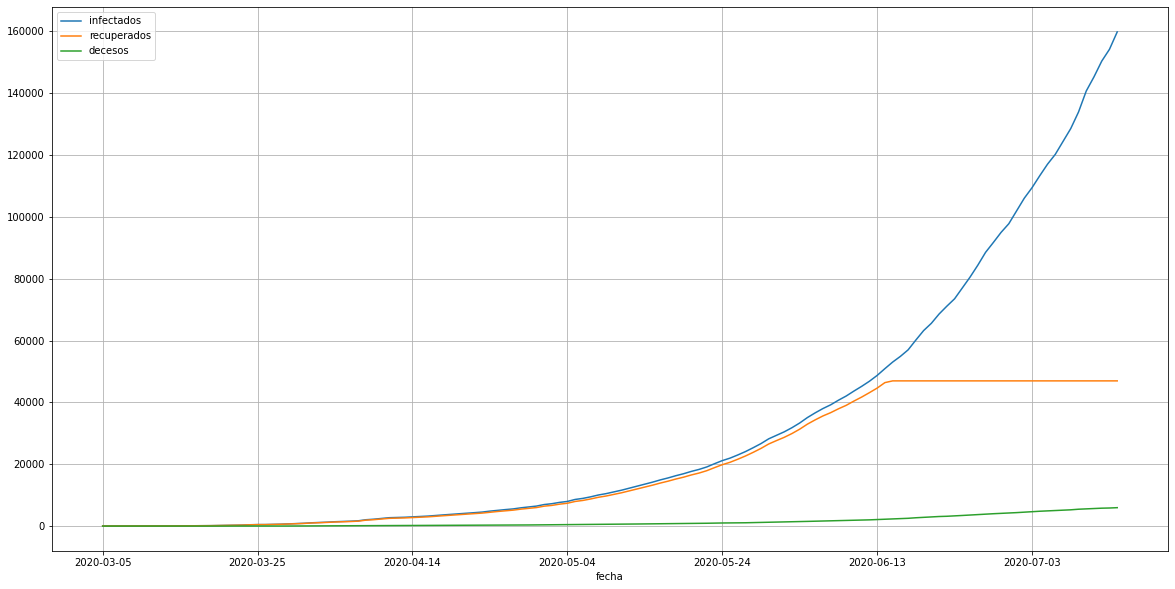

In [49]:
#df_seird_constantes_acum_col['fecha'] = df_seird_constantes_acum_col['fecha'].astype('datetime64[ns]')
df_seird_constantes_acum_col.plot(x='fecha', 
        y=['infectados', 'recuperados', 'decesos'], 
        kind='line', 
        figsize=(20, 10), 
        grid=True,
        legend=True,
        loglog=False
        )